In [1]:
# importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as ff
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def dataloader():
    """
    Returns dictionaries with torch tensors
    """
    train = MNIST("files/", download = True, transform = ToTensor())
    test = MNIST("files/", download = True, transform = ToTensor(), train = False)
    train_dict = {i:train.data[train.targets == i].data/1. for i in range(10)}
    test_dict = {i:test.data[test.targets == i].data/1. for i in range(10)}

    return train_dict, test_dict

train, test = dataloader()

/home/cmaspi/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


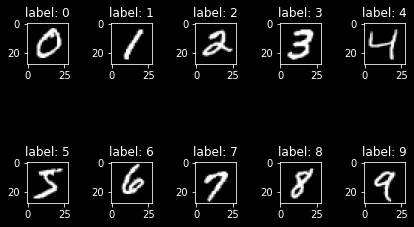

In [2]:
fig, ax = plt.subplots(2,5)
fig.tight_layout()
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(train[5*i+j][0].numpy(), cmap = 'gray')
        ax[i][j].set_title(f'label: {5*i+j}')

In [3]:
# taking 100 samples for each class for training
x_train = torch.cat([train[i][:100] for i in range(10)]).reshape(1000,1,28,28)
y_train = torch.div(torch.arange(1000, dtype=torch.int),100,rounding_mode='trunc').type(torch.LongTensor)

# taking 10 samples from each class for testing
x_test = torch.cat([test[i][:10] for i in range(10)]).reshape(100,1,28,28)
y_test = torch.div(torch.arange(100, dtype=torch.int),10,rounding_mode='trunc').type(torch.LongTensor)

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,4,5,padding = 2, padding_mode='reflect')
        self.conv1_ = nn.Sequential(nn.ReLU(),
                                    nn.MaxPool2d(2,2)) 
        self.conv2 = nn.Conv2d(4,4,5,padding = 2, padding_mode='reflect')
        self.conv2_ = nn.Sequential(nn.ReLU(), 
                                    nn.MaxPool2d(2,2)) 
        self.mlp1 = nn.Sequential(nn.Linear( 196, 49), 
                                    nn.ReLU())
        self.mlp2 = nn.Linear(49, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        x = self.conv2_(x)
        x = x.view(-1, 196)
        x = self.mlp1(x)
        x = self.mlp2(x)
        return x
    
    def viz(self, x):
        ret = []
        x = self.conv1(x)
        ret.append(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        ret.append(x)
        return ret


In [5]:
loss_func = nn.CrossEntropyLoss()

In [6]:
def shuffle(train: torch.tensor, labels: torch.tensor):
        """
        Shuffles the data in a random permutation
        """
        n = train.shape[0]
        permutation = torch.randperm(n)
        train = train[permutation]
        labels = labels[permutation]
        return train, labels

def iterate_minibatches(train : torch.tensor, labels: torch.tensor, batch_size : int, shuffle_ : bool = True):
        """
        Gives minibatches
        """
        if shuffle_:
            train, labels = shuffle(train, labels)
        for start_idx in range(0, train.shape[0] + 1 - batch_size, batch_size):
            excerpt = slice(start_idx, start_idx+batch_size)
            yield train[excerpt], labels[excerpt]

x_train, y_train = shuffle(x_train, y_train)


In [7]:
def predict_logits(network, samples):
    network.eval()
    pred = network.forward(samples)
    return pred

def predict(network, samples):
    pred = predict_logits(network, samples)
    pred = ff.softmax(pred, -1)
    return pred

def accuracy(predicted, ground_truth):
    predicted = torch.argmax(predicted, axis = -1)
    return torch.mean((predicted == ground_truth).to(float))

def train(network, train, ground_truth, epochs, batch_size, optimizer):
    train_errors = []
    test_errors = []
    network.train()
    for epoch in range(epochs):
        for x,y in iterate_minibatches(train, ground_truth, batch_size):
            optimizer.zero_grad()
            pred = network.forward(x)
            batch_loss = loss_func(pred, y)
            batch_loss.backward()
            optimizer.step()    
        pred_train = predict_logits(network, x_train)
        pred_test = predict_logits(network, x_test)
        train_errors.append(float(loss_func(pred_train, y_train)))    
        test_errors.append(float(loss_func(pred_test, y_test)))
        print(f'Epoch #{epoch+1}')
        print(f'training loss {train_errors[-1]}')
        print(f'testing loss {test_errors[-1]}')
        print(f'training accuracy {accuracy(pred_train, y_train)}')
        print(f'testing accuracy {accuracy(pred_test, y_test)}')
        # Displaying activation maps
        single_image = train[0].reshape(1,1,28,28)
        layer_activation = network.viz(single_image)
        fig,ax = plt.subplots(2,4, figsize=(12,3))
        ax[0][0].imshow(layer_activation[0][:,0,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[0][1].imshow(layer_activation[0][:,1,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[0][2].imshow(layer_activation[0][:,2,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[0][3].imshow(layer_activation[0][:,3,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[1][0].imshow(layer_activation[1][:,0,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        ax[1][1].imshow(layer_activation[1][:,1,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        ax[1][2].imshow(layer_activation[1][:,2,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        ax[1][3].imshow(layer_activation[1][:,3,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        plt.show()
        if epoch in [0,14]:
            logits = predict(network, x_test)
            X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits.detach().numpy())
            fig, ax = plt.subplots()
            for i in range(10):
                ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_test[10*i]}')
            ax.legend()
            plt.show()
    plt.plot(list(range(1,epochs+1)), train_errors, label = 'training loss')
    plt.plot(list(range(1,epochs+1)), test_errors, label = 'testing loss')
    plt.legend()
    plt.show()
        
        


# SGD with batch size = 15, learning rate = 0.01 (The model doesn't converge, it does converge if the learning rate is 0.1)

Epoch #1
training loss 1.6139034032821655
testing loss 1.8503100872039795
training accuracy 0.446
testing accuracy 0.31


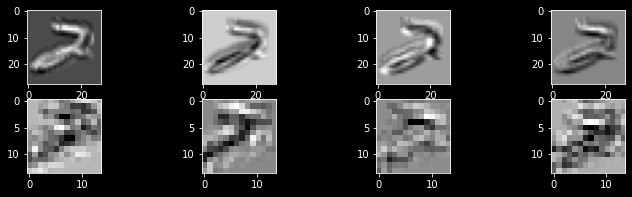

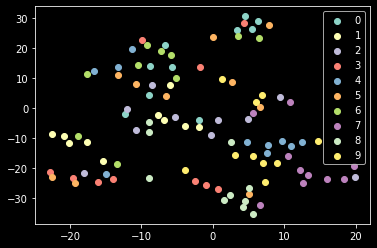

Epoch #2
training loss 0.8254343271255493
testing loss 1.1083496809005737
training accuracy 0.751
testing accuracy 0.67


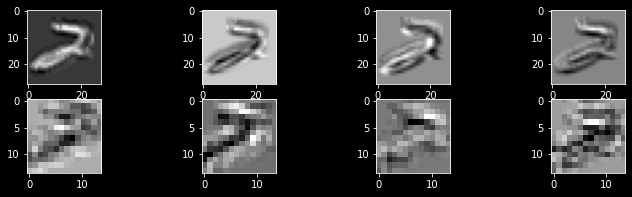

Epoch #3
training loss 0.558104932308197
testing loss 0.7075045704841614
training accuracy 0.838
testing accuracy 0.79


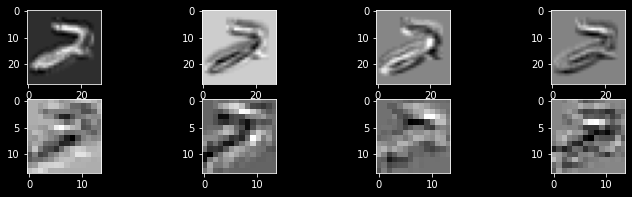

Epoch #4
training loss 0.43490728735923767
testing loss 0.6466563940048218
training accuracy 0.872
testing accuracy 0.8


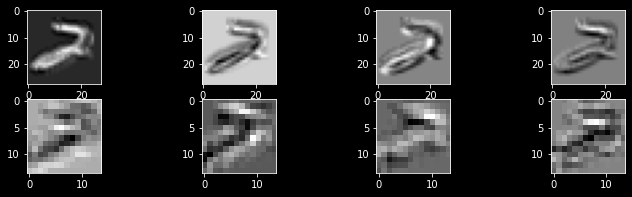

Epoch #5
training loss 0.30760809779167175
testing loss 0.4562003016471863
training accuracy 0.921
testing accuracy 0.85


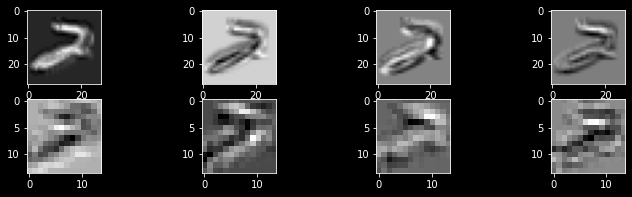

Epoch #6
training loss 0.26461806893348694
testing loss 0.3868519067764282
training accuracy 0.932
testing accuracy 0.87


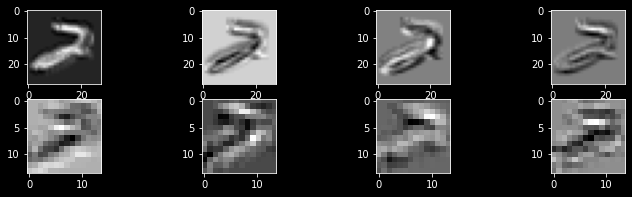

Epoch #7
training loss 0.2701626121997833
testing loss 0.43553584814071655
training accuracy 0.922
testing accuracy 0.82


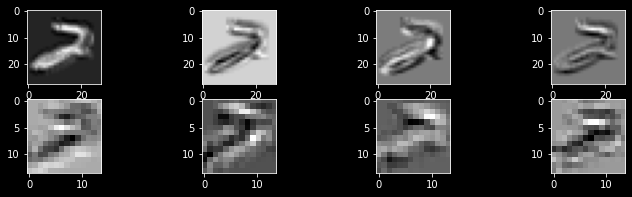

Epoch #8
training loss 0.1903260201215744
testing loss 0.30770012736320496
training accuracy 0.95
testing accuracy 0.88


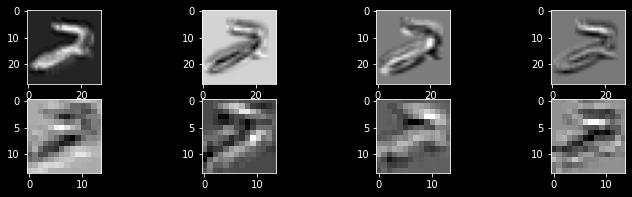

Epoch #9
training loss 0.15215133130550385
testing loss 0.21861135959625244
training accuracy 0.956
testing accuracy 0.93


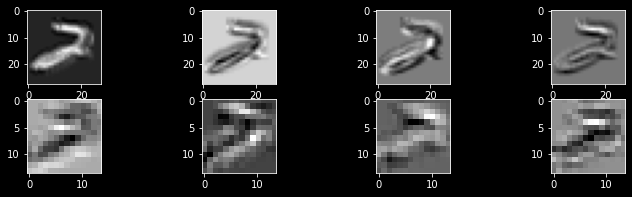

Epoch #10
training loss 0.13826541602611542
testing loss 0.18960562348365784
training accuracy 0.965
testing accuracy 0.94


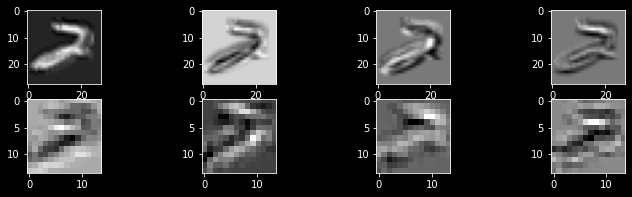

Epoch #11
training loss 0.11078857630491257
testing loss 0.17799003422260284
training accuracy 0.976
testing accuracy 0.92


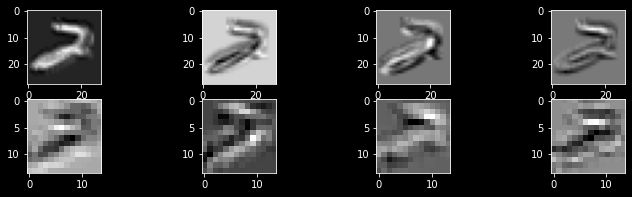

Epoch #12
training loss 0.08882395178079605
testing loss 0.13805043697357178
training accuracy 0.98
testing accuracy 0.95


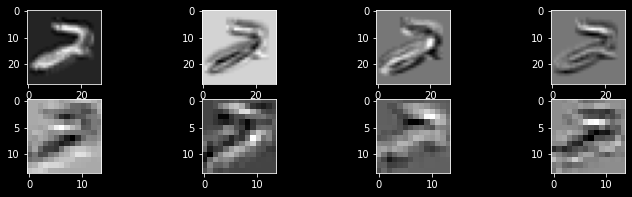

Epoch #13
training loss 0.09745707362890244
testing loss 0.16598770022392273
training accuracy 0.973
testing accuracy 0.93


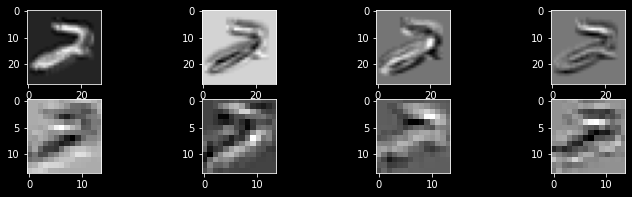

Epoch #14
training loss 0.06216704472899437
testing loss 0.12393014878034592
training accuracy 0.985
testing accuracy 0.97


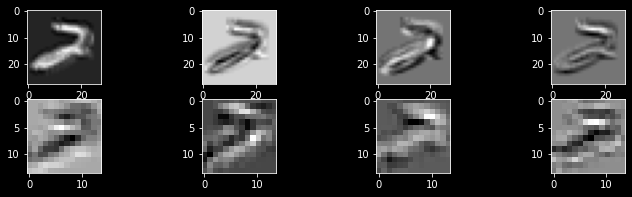

Epoch #15
training loss 0.06764886528253555
testing loss 0.1660517305135727
training accuracy 0.983
testing accuracy 0.94


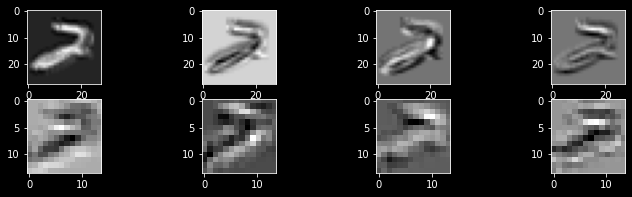

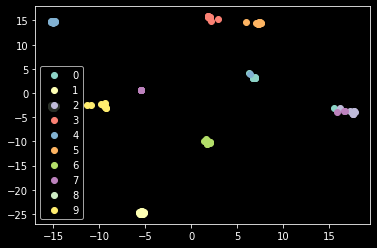

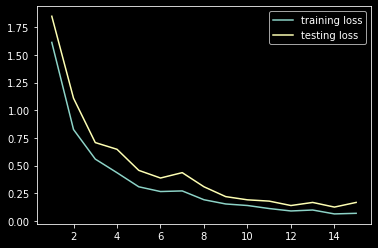

In [8]:
network = Network()
optimizer_SGD = optim.SGD(network.parameters(), lr=0.001)
train(network, x_train, y_train, 15, 15, optimizer_SGD)

# Momentum, batch size = 15

Epoch #1
training loss 1.3193250894546509
testing loss 1.333606243133545
training accuracy 0.572
testing accuracy 0.52


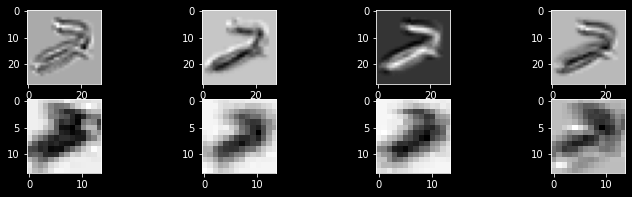

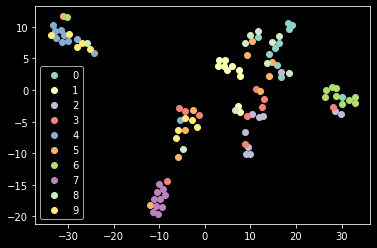

Epoch #2
training loss 0.6630271673202515
testing loss 0.8016163110733032
training accuracy 0.781
testing accuracy 0.72


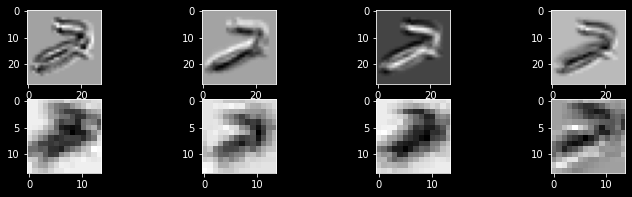

Epoch #3
training loss 0.7497140169143677
testing loss 0.8395149111747742
training accuracy 0.819
testing accuracy 0.78


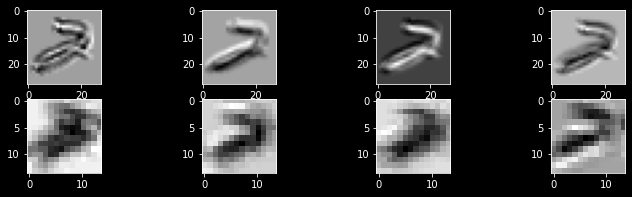

Epoch #4
training loss 0.25087568163871765
testing loss 0.46462762355804443
training accuracy 0.914
testing accuracy 0.87


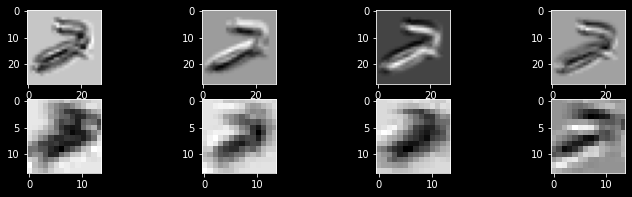

Epoch #5
training loss 0.17658889293670654
testing loss 0.34582510590553284
training accuracy 0.945
testing accuracy 0.89


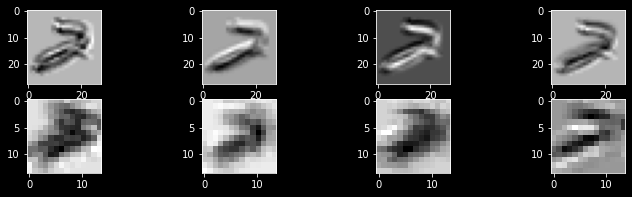

Epoch #6
training loss 0.1487259864807129
testing loss 0.4320801794528961
training accuracy 0.954
testing accuracy 0.85


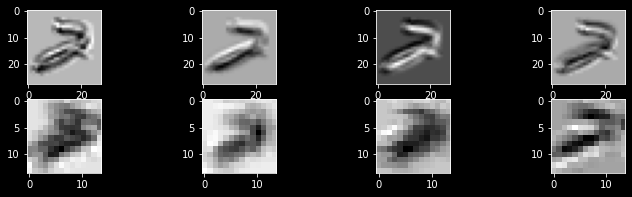

Epoch #7
training loss 0.08914504945278168
testing loss 0.3010726273059845
training accuracy 0.973
testing accuracy 0.88


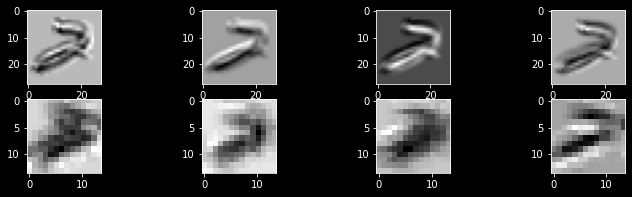

Epoch #8
training loss 0.0959872379899025
testing loss 0.383870005607605
training accuracy 0.972
testing accuracy 0.87


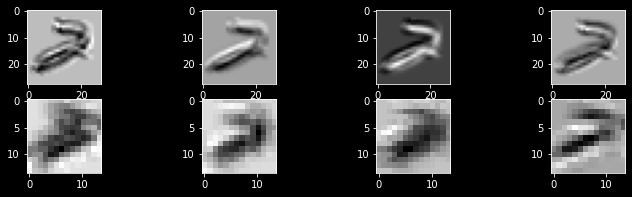

Epoch #9
training loss 0.08047178387641907
testing loss 0.4618207812309265
training accuracy 0.973
testing accuracy 0.88


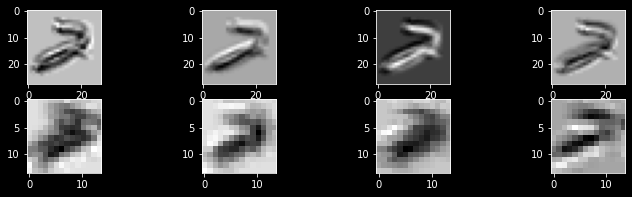

Epoch #10
training loss 0.034950435161590576
testing loss 0.3536236882209778
training accuracy 0.989
testing accuracy 0.89


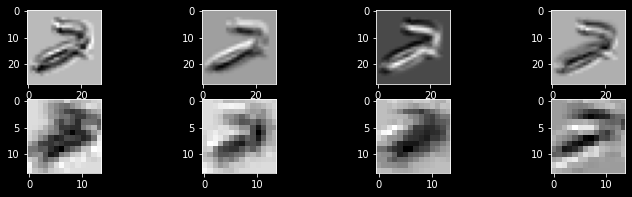

Epoch #11
training loss 0.0402265265583992
testing loss 0.2697383165359497
training accuracy 0.99
testing accuracy 0.96


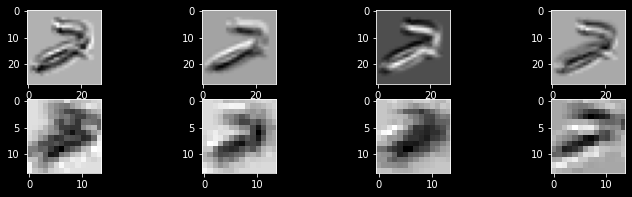

Epoch #12
training loss 0.010713563300669193
testing loss 0.29695650935173035
training accuracy 0.997
testing accuracy 0.92


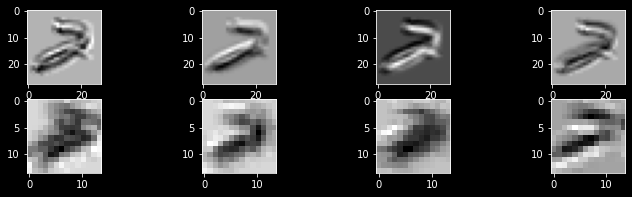

Epoch #13
training loss 0.00420326879248023
testing loss 0.22590486705303192
training accuracy 1.0
testing accuracy 0.93


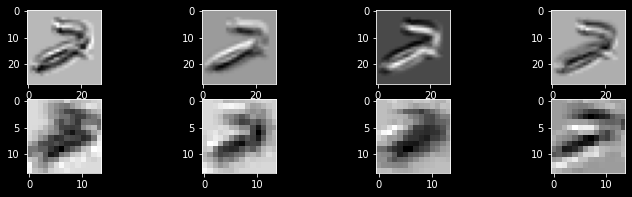

Epoch #14
training loss 0.0014364561066031456
testing loss 0.21980945765972137
training accuracy 1.0
testing accuracy 0.93


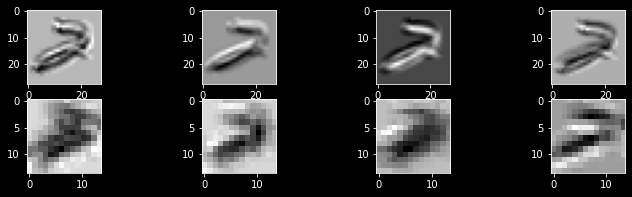

Epoch #15
training loss 0.0011098535032942891
testing loss 0.21401959657669067
training accuracy 1.0
testing accuracy 0.95


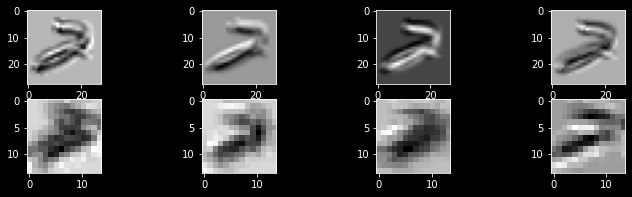

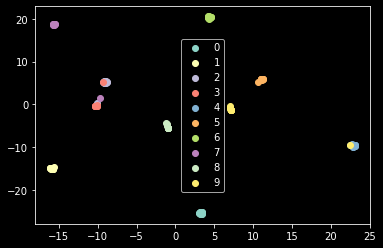

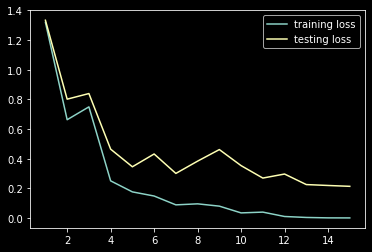

In [9]:
network = Network()
optimizer_momentum = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
train(network, x_train, y_train, 15, 15, optimizer_momentum)

# RMS prop, batch size = 15

Epoch #1
training loss 0.45748868584632874
testing loss 0.6520912647247314
training accuracy 0.854
testing accuracy 0.82


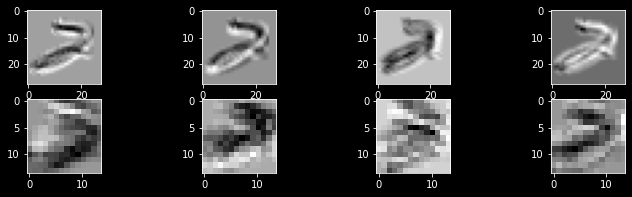

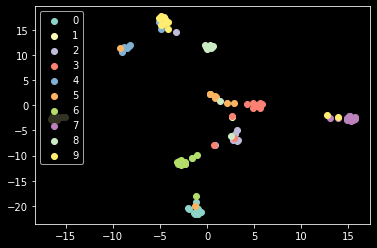

Epoch #2
training loss 0.17822475731372833
testing loss 0.3564477264881134
training accuracy 0.95
testing accuracy 0.91


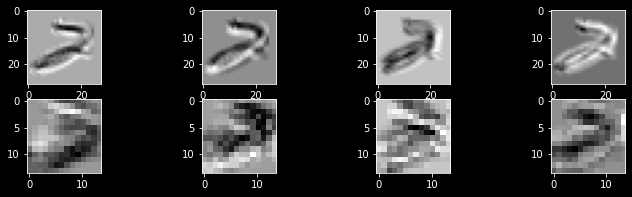

Epoch #3
training loss 0.08941598981618881
testing loss 0.30265969038009644
training accuracy 0.974
testing accuracy 0.89


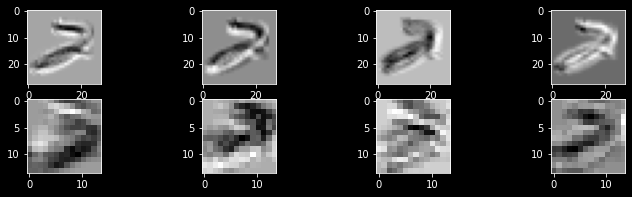

Epoch #4
training loss 0.07920892536640167
testing loss 0.3006052076816559
training accuracy 0.976
testing accuracy 0.92


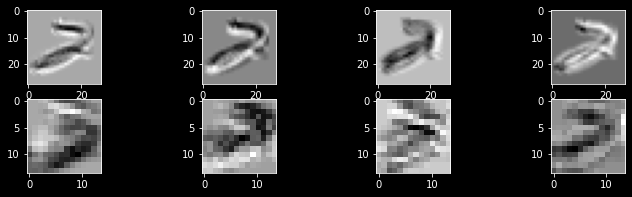

Epoch #5
training loss 0.041330985724925995
testing loss 0.22142894566059113
training accuracy 0.992
testing accuracy 0.91


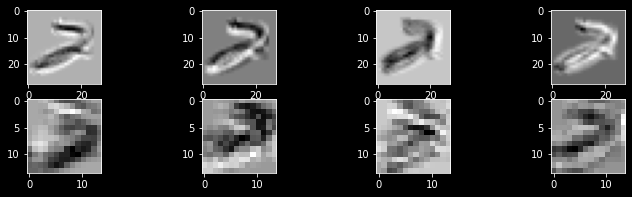

Epoch #6
training loss 0.014525095000863075
testing loss 0.20050746202468872
training accuracy 0.998
testing accuracy 0.93


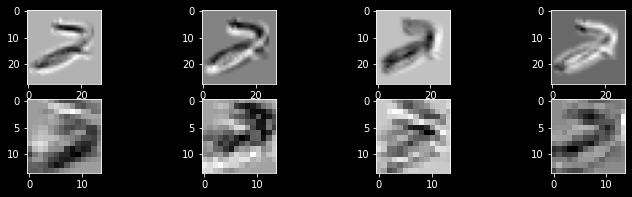

Epoch #7
training loss 0.010999718680977821
testing loss 0.21204110980033875
training accuracy 0.997
testing accuracy 0.95


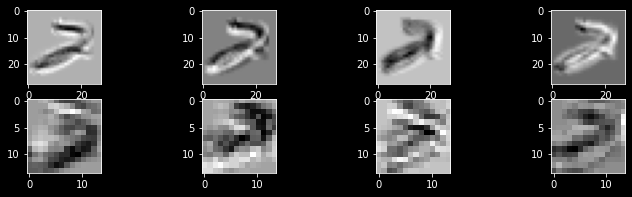

Epoch #8
training loss 0.006316725164651871
testing loss 0.1487986296415329
training accuracy 1.0
testing accuracy 0.96


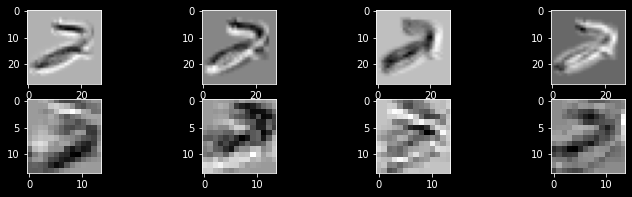

Epoch #9
training loss 0.010039751417934895
testing loss 0.18636710941791534
training accuracy 0.997
testing accuracy 0.95


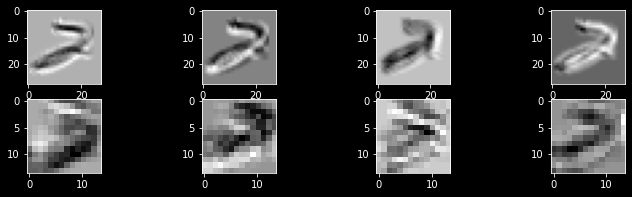

Epoch #10
training loss 0.01421735156327486
testing loss 0.11037273705005646
training accuracy 0.994
testing accuracy 0.98


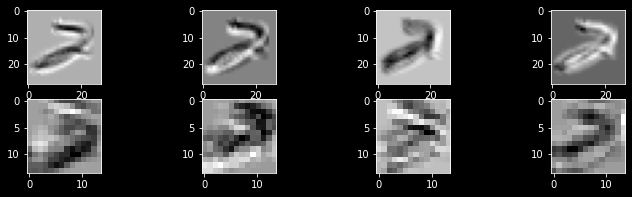

Epoch #11
training loss 0.0022975667379796505
testing loss 0.1958574503660202
training accuracy 1.0
testing accuracy 0.95


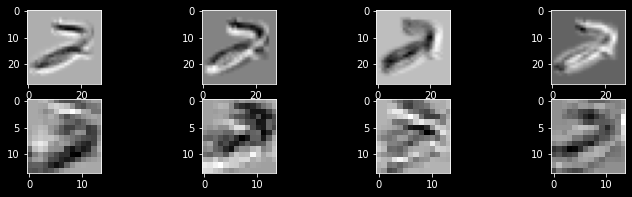

Epoch #12
training loss 0.0013381068129092455
testing loss 0.12737077474594116
training accuracy 1.0
testing accuracy 0.97


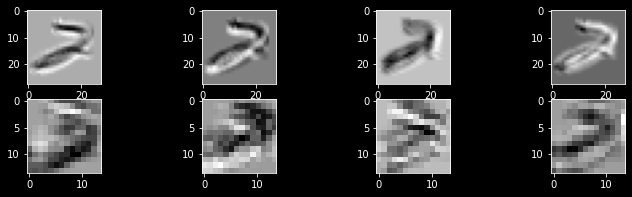

Epoch #13
training loss 0.00454821577295661
testing loss 0.1810869425535202
training accuracy 0.998
testing accuracy 0.96


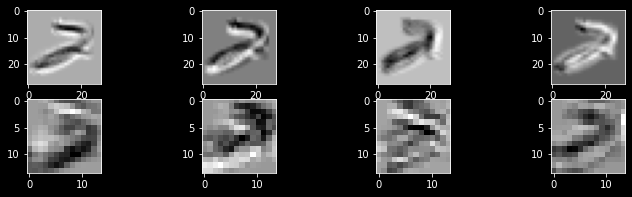

Epoch #14
training loss 0.0025439977180212736
testing loss 0.1931331604719162
training accuracy 0.999
testing accuracy 0.95


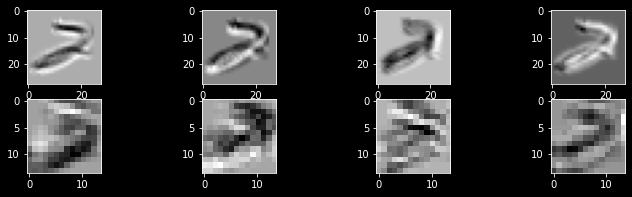

Epoch #15
training loss 0.0131364855915308
testing loss 0.4936768412590027
training accuracy 0.996
testing accuracy 0.92


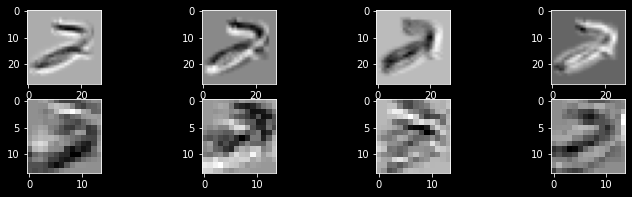

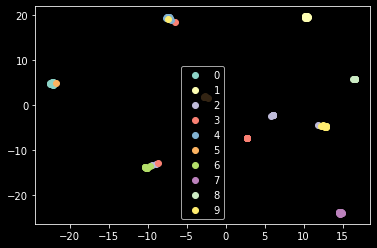

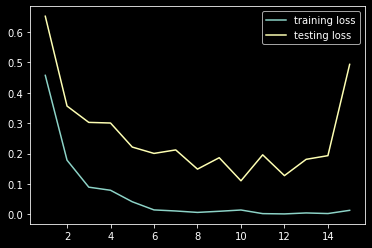

In [10]:
network = Network()
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

# SGD with batch size = 50, learning rate = 0.01 (The model doesn't converge, it does converge if the learning rate is 0.1)

Epoch #1
training loss 2.0586347579956055
testing loss 2.1357223987579346
training accuracy 0.291
testing accuracy 0.29


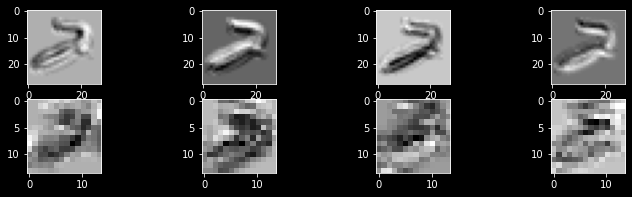

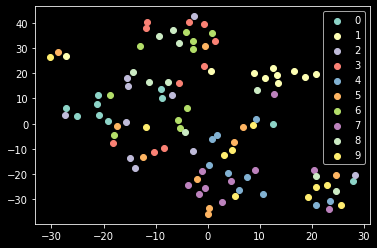

Epoch #2
training loss 1.7327996492385864
testing loss 1.8668806552886963
training accuracy 0.424
testing accuracy 0.37


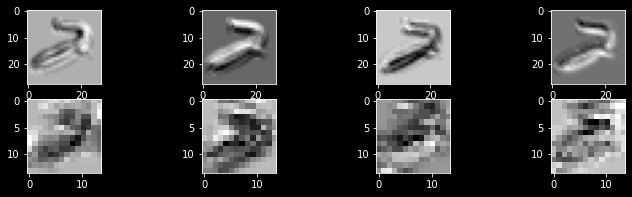

Epoch #3
training loss 1.4669002294540405
testing loss 1.649733066558838
training accuracy 0.534
testing accuracy 0.46


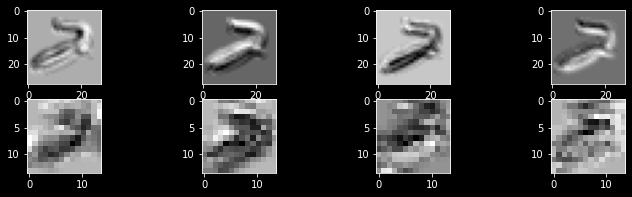

Epoch #4
training loss 1.2411445379257202
testing loss 1.4452799558639526
training accuracy 0.614
testing accuracy 0.52


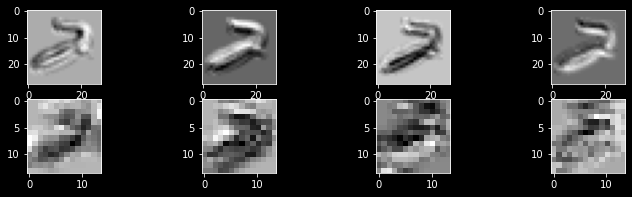

Epoch #5
training loss 1.0578396320343018
testing loss 1.2836976051330566
training accuracy 0.682
testing accuracy 0.56


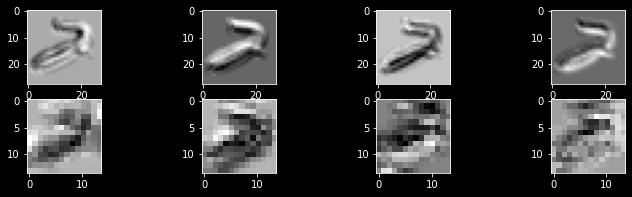

Epoch #6
training loss 0.9038789868354797
testing loss 1.138290286064148
training accuracy 0.717
testing accuracy 0.63


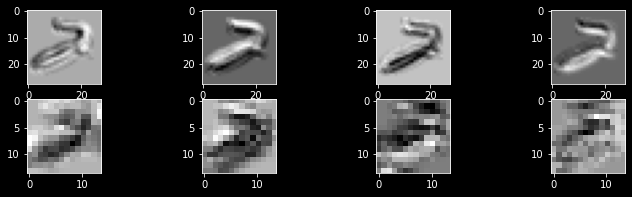

Epoch #7
training loss 0.7806064486503601
testing loss 1.012255072593689
training accuracy 0.763
testing accuracy 0.67


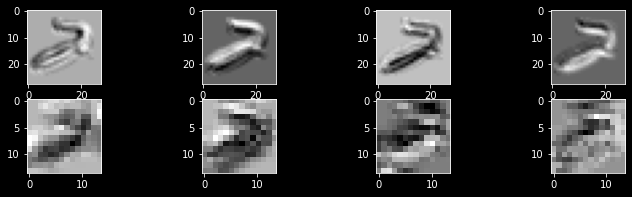

Epoch #8
training loss 0.6777318716049194
testing loss 0.9227537512779236
training accuracy 0.797
testing accuracy 0.72


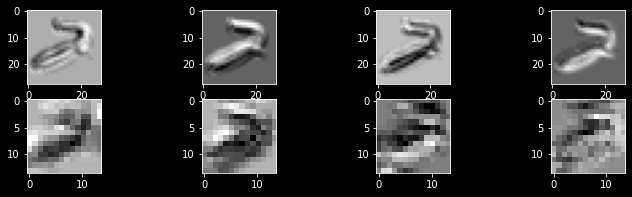

Epoch #9
training loss 0.608146071434021
testing loss 0.8717476725578308
training accuracy 0.809
testing accuracy 0.74


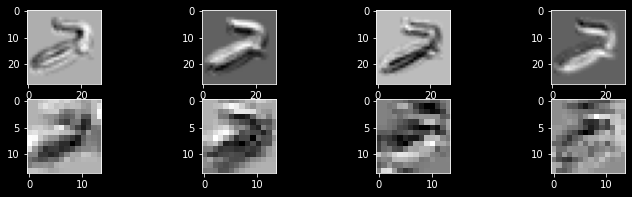

Epoch #10
training loss 0.543185293674469
testing loss 0.796491265296936
training accuracy 0.839
testing accuracy 0.76


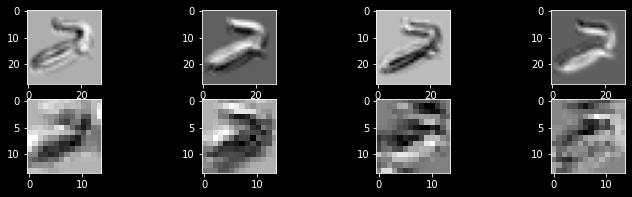

Epoch #11
training loss 0.4899793565273285
testing loss 0.7149764895439148
training accuracy 0.853
testing accuracy 0.78


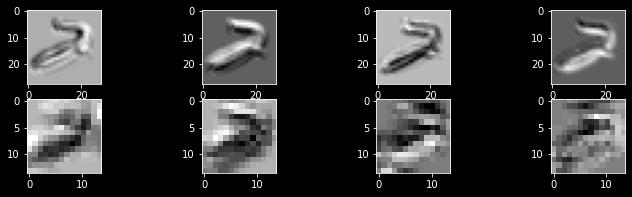

Epoch #12
training loss 0.45330479741096497
testing loss 0.6709846258163452
training accuracy 0.86
testing accuracy 0.81


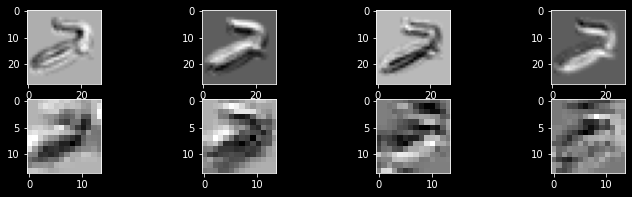

Epoch #13
training loss 0.4047539234161377
testing loss 0.6397050023078918
training accuracy 0.871
testing accuracy 0.81


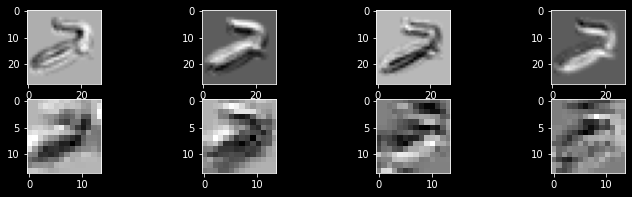

Epoch #14
training loss 0.3743574619293213
testing loss 0.6144317388534546
training accuracy 0.887
testing accuracy 0.81


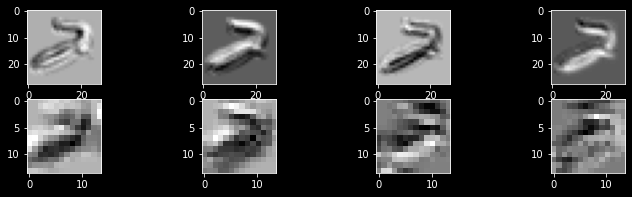

Epoch #15
training loss 0.3507811725139618
testing loss 0.6024793386459351
training accuracy 0.89
testing accuracy 0.82


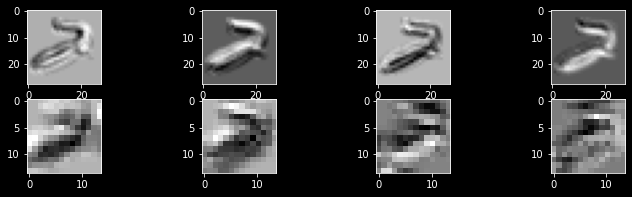

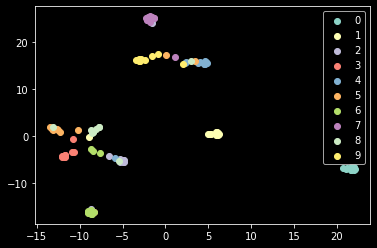

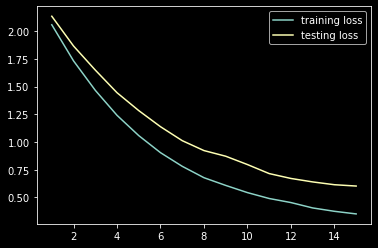

In [11]:
network = Network()
optimizer_SGD = optim.SGD(network.parameters(), lr=0.001)
train(network, x_train, y_train, 15, 50, optimizer_SGD)

# Momentum, batch size = 50

Epoch #1
training loss 2.1147093772888184
testing loss 2.1013782024383545
training accuracy 0.283
testing accuracy 0.3


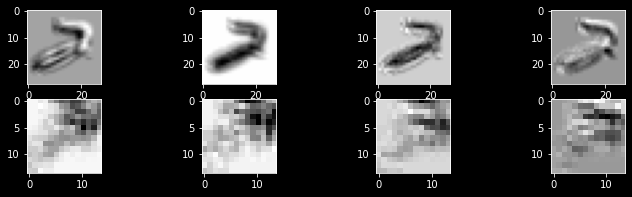

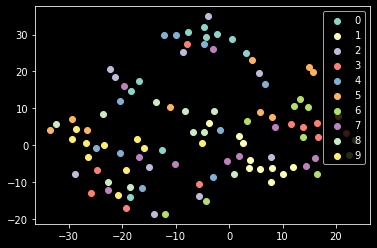

Epoch #2
training loss 1.3220951557159424
testing loss 1.4595515727996826
training accuracy 0.576
testing accuracy 0.46


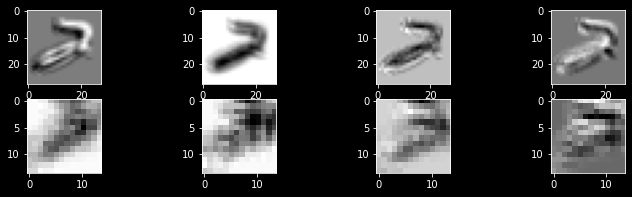

Epoch #3
training loss 0.7995299100875854
testing loss 0.9380413293838501
training accuracy 0.742
testing accuracy 0.69


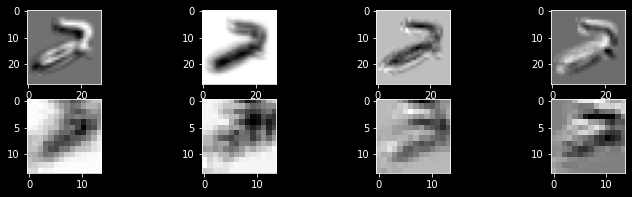

Epoch #4
training loss 0.4992654323577881
testing loss 0.6223673224449158
training accuracy 0.85
testing accuracy 0.79


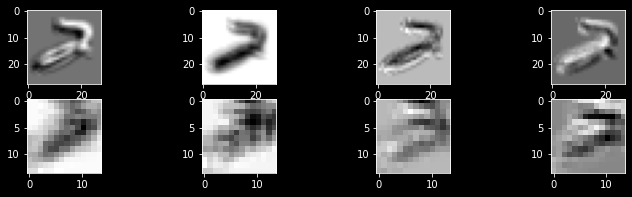

Epoch #5
training loss 0.3740110993385315
testing loss 0.4364098310470581
training accuracy 0.886
testing accuracy 0.84


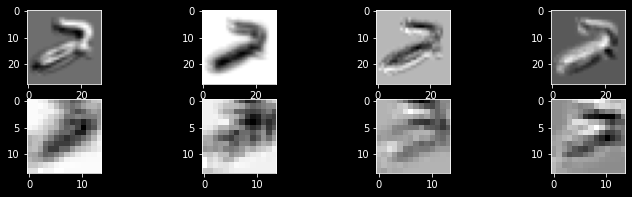

Epoch #6
training loss 0.2663240134716034
testing loss 0.45874354243278503
training accuracy 0.919
testing accuracy 0.87


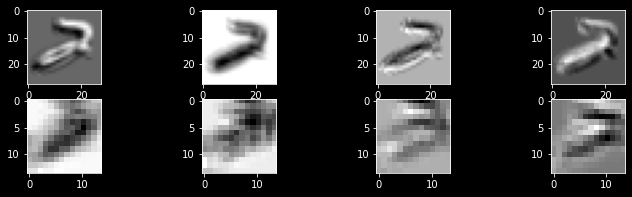

Epoch #7
training loss 0.20904441177845
testing loss 0.3630286455154419
training accuracy 0.938
testing accuracy 0.9


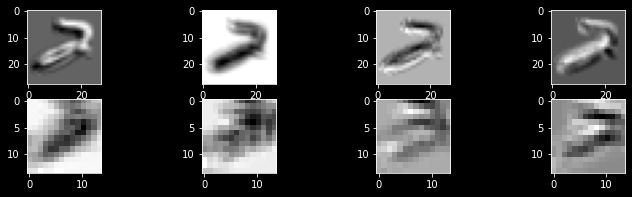

Epoch #8
training loss 0.16639451682567596
testing loss 0.47706377506256104
training accuracy 0.951
testing accuracy 0.83


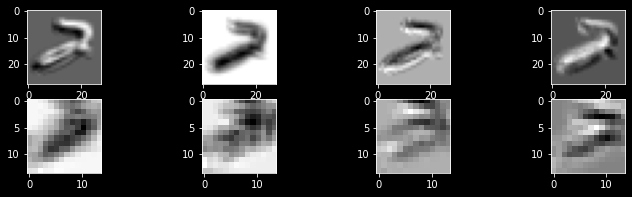

Epoch #9
training loss 0.1365044116973877
testing loss 0.4141792356967926
training accuracy 0.961
testing accuracy 0.82


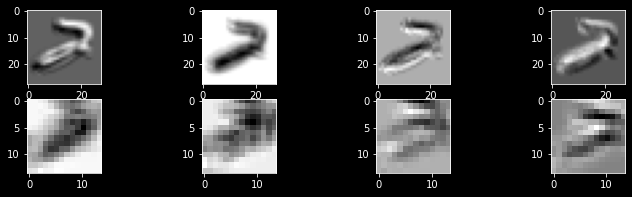

Epoch #10
training loss 0.10934343934059143
testing loss 0.3666335940361023
training accuracy 0.968
testing accuracy 0.92


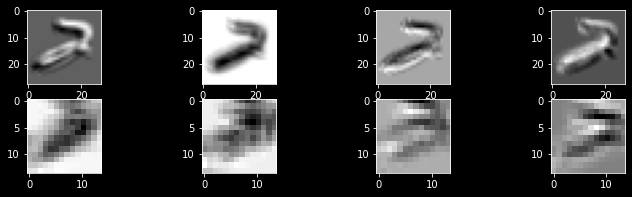

Epoch #11
training loss 0.08744136989116669
testing loss 0.3809765577316284
training accuracy 0.979
testing accuracy 0.88


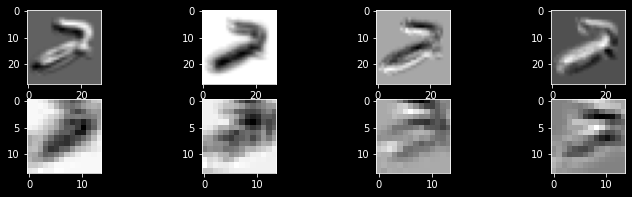

Epoch #12
training loss 0.08345584571361542
testing loss 0.4285188913345337
training accuracy 0.975
testing accuracy 0.87


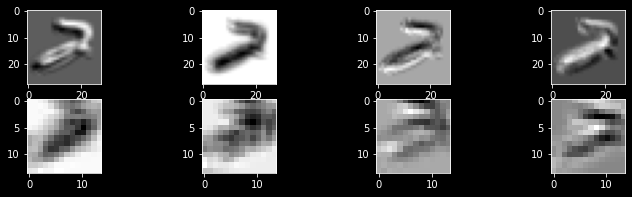

Epoch #13
training loss 0.06348773092031479
testing loss 0.340536504983902
training accuracy 0.983
testing accuracy 0.89


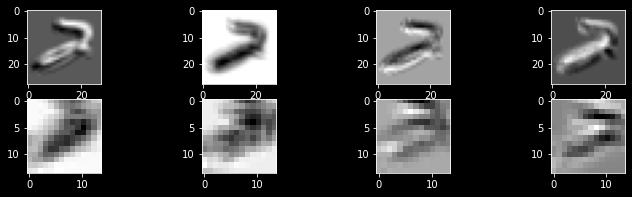

Epoch #14
training loss 0.04598451033234596
testing loss 0.36994388699531555
training accuracy 0.985
testing accuracy 0.89


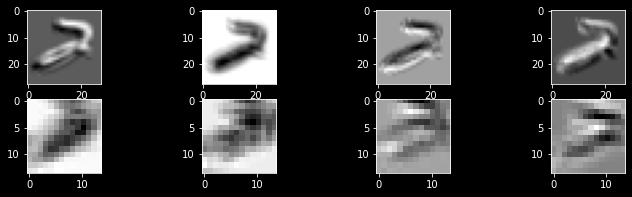

Epoch #15
training loss 0.03983122855424881
testing loss 0.34706389904022217
training accuracy 0.992
testing accuracy 0.89


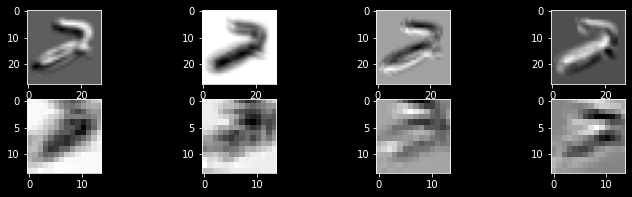

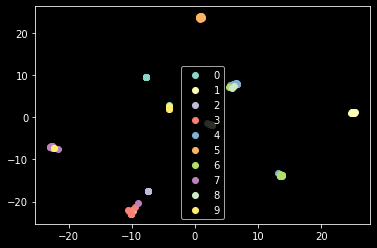

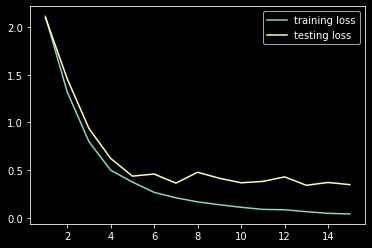

In [12]:
network = Network()
optimizer_momentum = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
train(network, x_train, y_train, 15, 50, optimizer_momentum)

# RMSprop, batch size = 50

Epoch #1
training loss 0.9235372543334961
testing loss 1.0385174751281738
training accuracy 0.69
testing accuracy 0.66


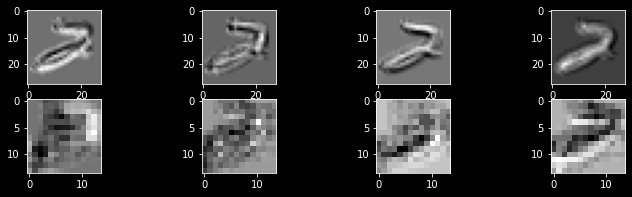

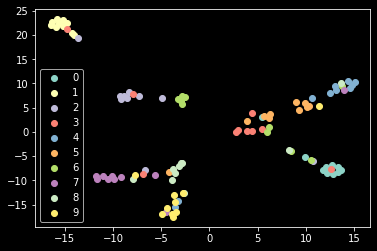

Epoch #2
training loss 0.47519439458847046
testing loss 0.6271908283233643
training accuracy 0.848
testing accuracy 0.77


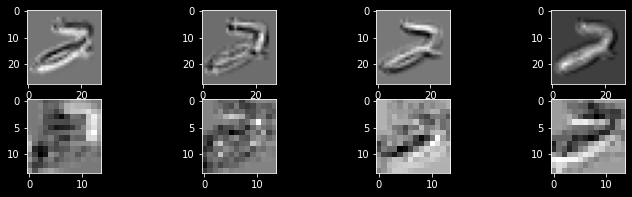

Epoch #3
training loss 0.2956186532974243
testing loss 0.47776153683662415
training accuracy 0.913
testing accuracy 0.85


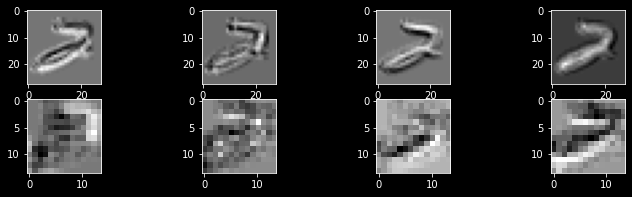

Epoch #4
training loss 0.2511932849884033
testing loss 0.5224343538284302
training accuracy 0.917
testing accuracy 0.81


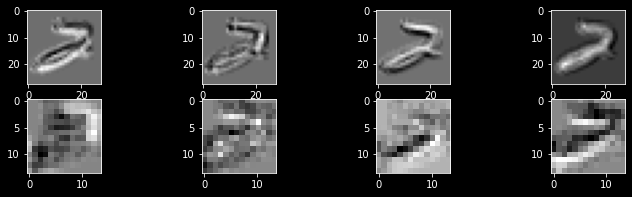

Epoch #5
training loss 0.14438194036483765
testing loss 0.407938688993454
training accuracy 0.956
testing accuracy 0.87


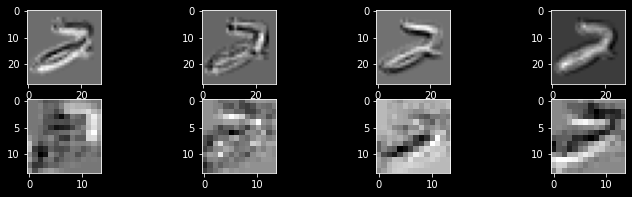

Epoch #6
training loss 0.10605841130018234
testing loss 0.41695237159729004
training accuracy 0.971
testing accuracy 0.85


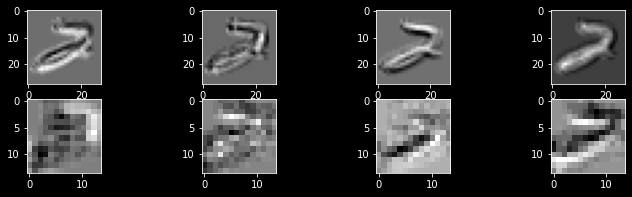

Epoch #7
training loss 0.07768405228853226
testing loss 0.4085243344306946
training accuracy 0.974
testing accuracy 0.87


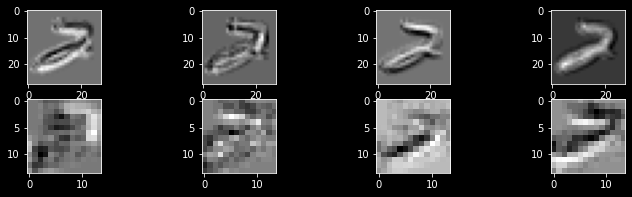

Epoch #8
training loss 0.09662075340747833
testing loss 0.5124949812889099
training accuracy 0.969
testing accuracy 0.84


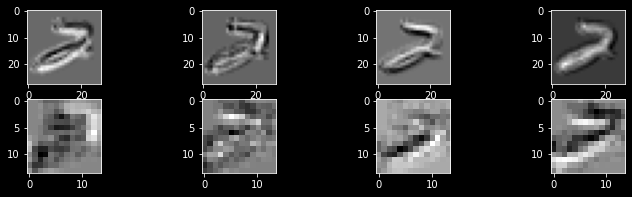

Epoch #9
training loss 0.02994234673678875
testing loss 0.26135674118995667
training accuracy 0.996
testing accuracy 0.89


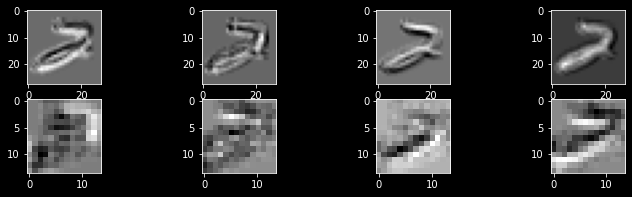

Epoch #10
training loss 0.01825164631009102
testing loss 0.30026233196258545
training accuracy 0.999
testing accuracy 0.92


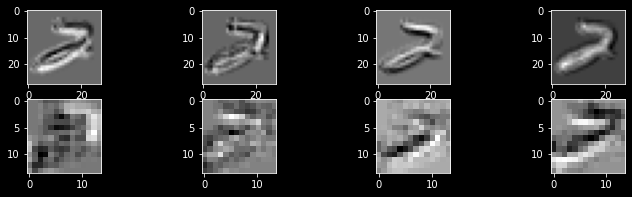

Epoch #11
training loss 0.06873607635498047
testing loss 0.392892986536026
training accuracy 0.969
testing accuracy 0.89


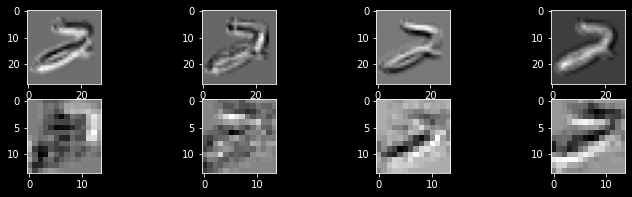

Epoch #12
training loss 0.02099025808274746
testing loss 0.2845733165740967
training accuracy 0.996
testing accuracy 0.9


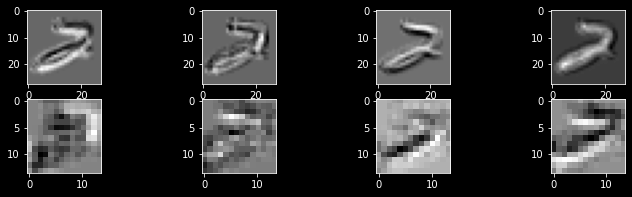

Epoch #13
training loss 0.015472459606826305
testing loss 0.3435610234737396
training accuracy 0.997
testing accuracy 0.91


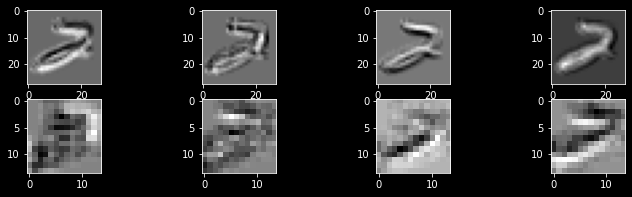

Epoch #14
training loss 0.001342384610325098
testing loss 0.20187434554100037
training accuracy 1.0
testing accuracy 0.93


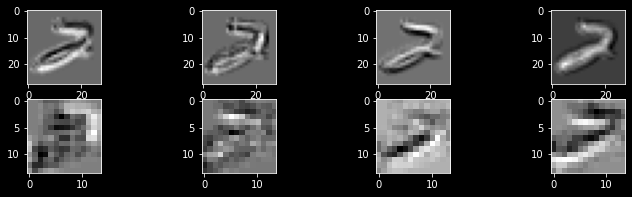

Epoch #15
training loss 0.3109795153141022
testing loss 0.6574829816818237
training accuracy 0.926
testing accuracy 0.88


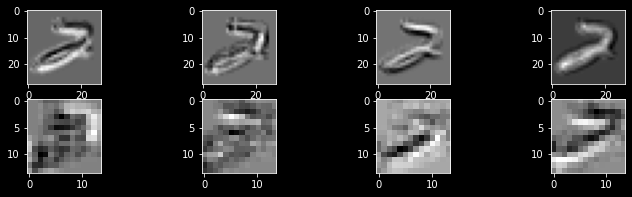

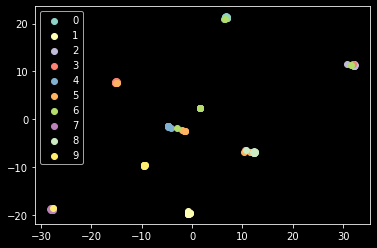

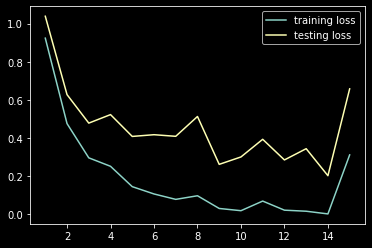

In [13]:
network = Network()
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 50, optimizer_rmsprop)

# Question-5
I'm getting slightly higher accuracy using pytorch implementation, this implementation is also significantly faster, it runs in 10 seconds, while my numpy implementation took nearly 20 minutes
I was getting mosstly between 80-92% accyracy in my implementation, while, now I'm getting more than 90 always, and it goes upto 98% at times.

The results are different for higher batch size though. the results from my implementation were more or less similar for the two batch sizes I chose, but here the accuracy seems to be far less for batch size 50 in pytorch implementation.

# Drop out
Question - 6

In [14]:
class Network_dropout(nn.Module):
    def __init__(self, p):
        self.p = p
        super(Network_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1,4,5,padding = 2)
        self.conv1_ = nn.Sequential(nn.ReLU(),
                                    nn.MaxPool2d(2,2)) 
        self.conv2 = nn.Conv2d(4,4,5,padding = 2)
        self.conv2_ = nn.Sequential(nn.ReLU(), 
                                    nn.MaxPool2d(2,2)) 
        self.mlp1 = nn.Sequential(nn.Linear( 196, 49), 
                                    nn.ReLU(),
                                    nn.Dropout(p = self.p))
        self.mlp2 = nn.Linear(49, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        x = self.conv2_(x)
        x = x.view(-1, 196)
        x = self.mlp1(x)
        x = self.mlp2(x)
        return x
    
    def viz(self, x):
        ret = []
        x = self.conv1(x)
        ret.append(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        ret.append(x)
        return ret


dropout rate 0.2

Epoch #1
training loss 0.5728091597557068
testing loss 0.6704059839248657
training accuracy 0.832
testing accuracy 0.8


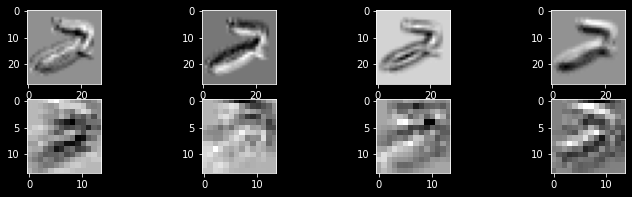

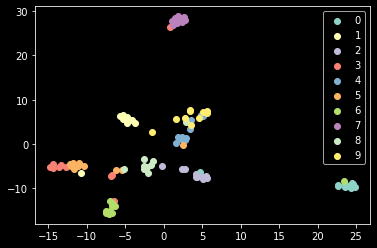

Epoch #2
training loss 0.2550666332244873
testing loss 0.32201454043388367
training accuracy 0.92
testing accuracy 0.88


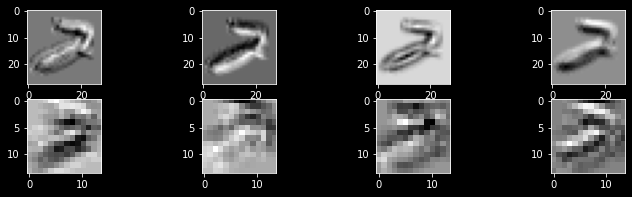

Epoch #3
training loss 0.15915414690971375
testing loss 0.27322596311569214
training accuracy 0.957
testing accuracy 0.91


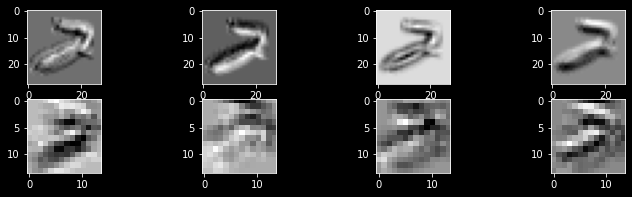

Epoch #4
training loss 0.11603360623121262
testing loss 0.31117114424705505
training accuracy 0.962
testing accuracy 0.91


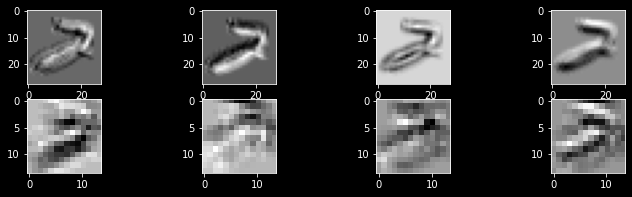

Epoch #5
training loss 0.05786341428756714
testing loss 0.17093665897846222
training accuracy 0.98
testing accuracy 0.95


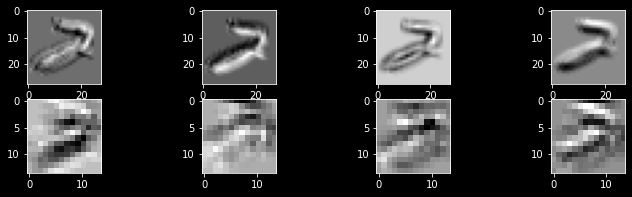

Epoch #6
training loss 0.03420333191752434
testing loss 0.20422790944576263
training accuracy 0.992
testing accuracy 0.92


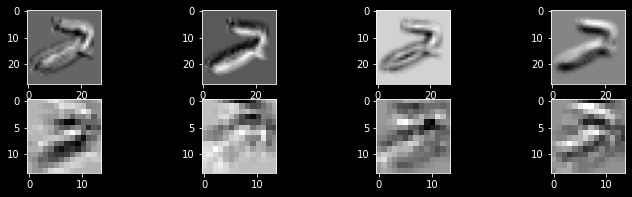

Epoch #7
training loss 0.027530336752533913
testing loss 0.225153848528862
training accuracy 0.992
testing accuracy 0.93


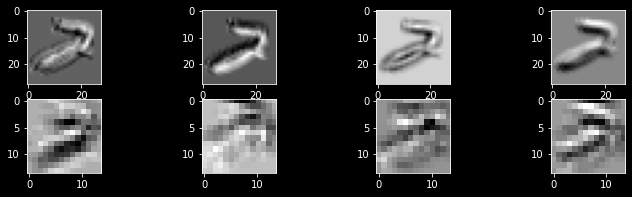

Epoch #8
training loss 0.006012178957462311
testing loss 0.1849810630083084
training accuracy 1.0
testing accuracy 0.93


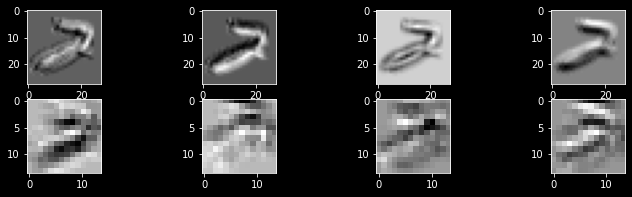

Epoch #9
training loss 0.01092503685504198
testing loss 0.20665453374385834
training accuracy 0.998
testing accuracy 0.89


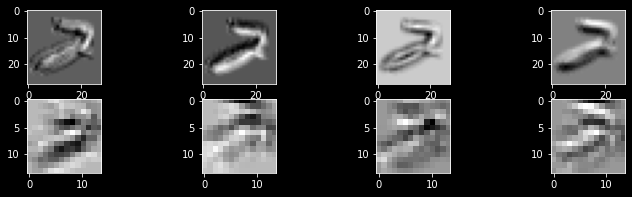

Epoch #10
training loss 0.006372031755745411
testing loss 0.27335962653160095
training accuracy 1.0
testing accuracy 0.93


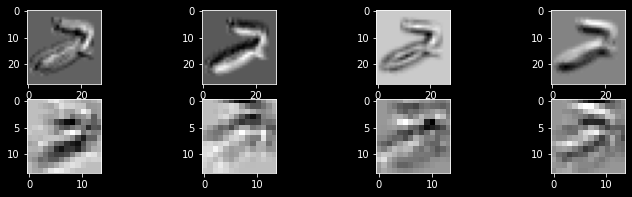

Epoch #11
training loss 0.013551280833780766
testing loss 0.336979478597641
training accuracy 0.995
testing accuracy 0.93


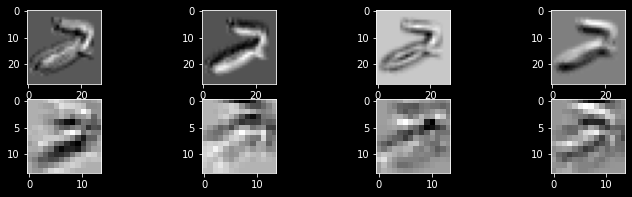

Epoch #12
training loss 0.019526954740285873
testing loss 0.46736404299736023
training accuracy 0.99
testing accuracy 0.94


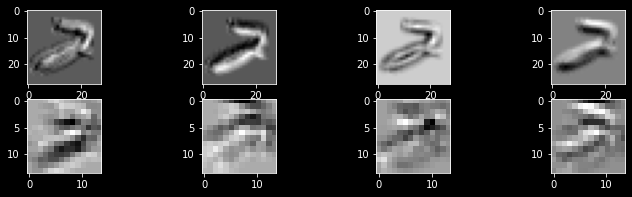

Epoch #13
training loss 0.004678493365645409
testing loss 0.21500997245311737
training accuracy 0.998
testing accuracy 0.93


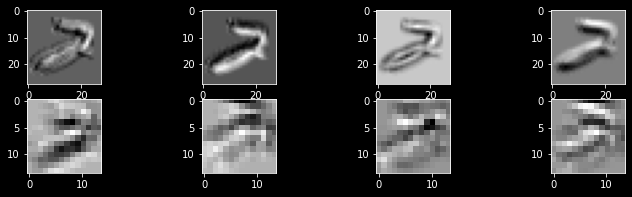

Epoch #14
training loss 0.0010338800493627787
testing loss 0.22490444779396057
training accuracy 1.0
testing accuracy 0.95


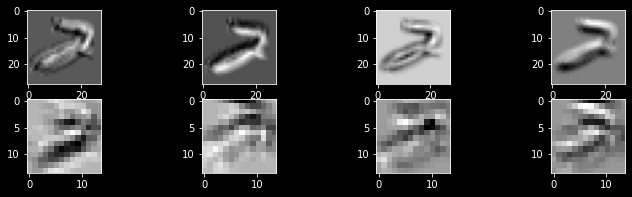

Epoch #15
training loss 0.0007228414178825915
testing loss 0.2339291125535965
training accuracy 1.0
testing accuracy 0.94


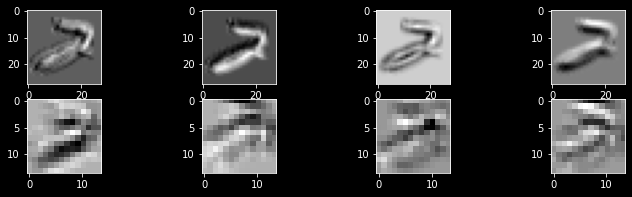

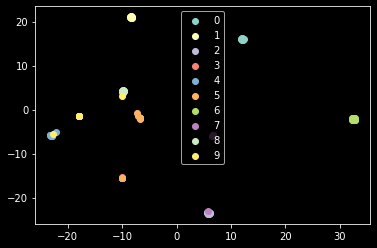

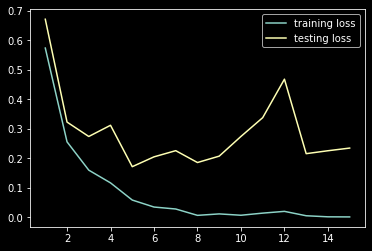

In [15]:
network = Network_dropout(.2)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

dropout rate 0.5

Epoch #1
training loss 1.1048330068588257
testing loss 1.3462073802947998
training accuracy 0.696
testing accuracy 0.63


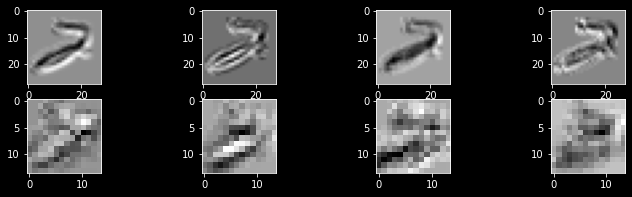

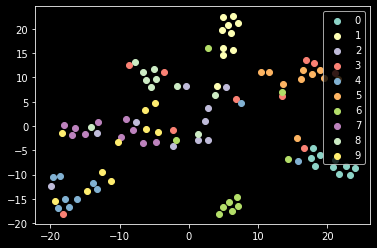

Epoch #2
training loss 0.32962676882743835
testing loss 0.6360059380531311
training accuracy 0.904
testing accuracy 0.81


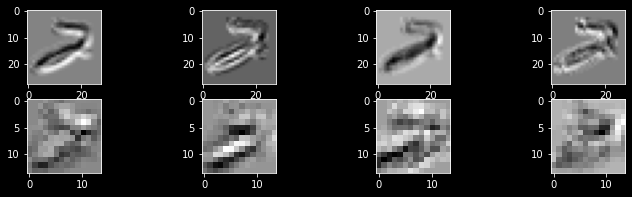

Epoch #3
training loss 0.1784917414188385
testing loss 0.4121536314487457
training accuracy 0.946
testing accuracy 0.85


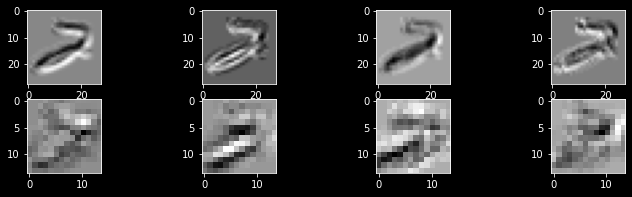

Epoch #4
training loss 0.11102809011936188
testing loss 0.3111807703971863
training accuracy 0.965
testing accuracy 0.91


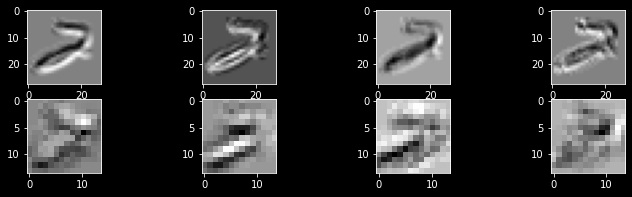

Epoch #5
training loss 0.08332688361406326
testing loss 0.4231346547603607
training accuracy 0.977
testing accuracy 0.85


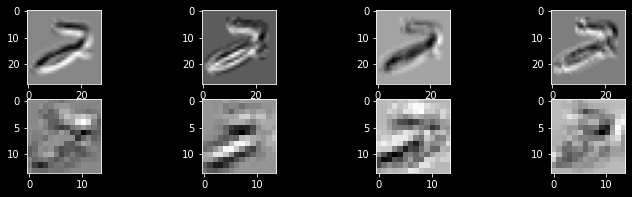

Epoch #6
training loss 0.05408402532339096
testing loss 0.20793233811855316
training accuracy 0.98
testing accuracy 0.89


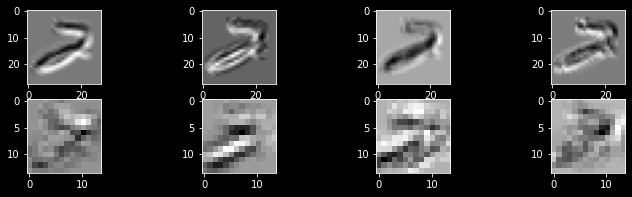

Epoch #7
training loss 0.04151119291782379
testing loss 0.27156364917755127
training accuracy 0.988
testing accuracy 0.91


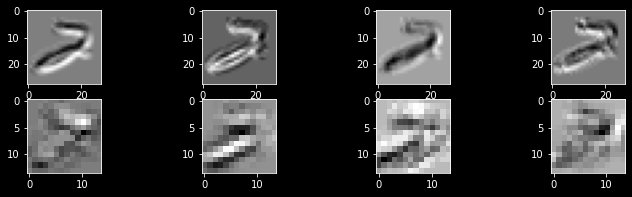

Epoch #8
training loss 0.007837152108550072
testing loss 0.22744566202163696
training accuracy 0.998
testing accuracy 0.91


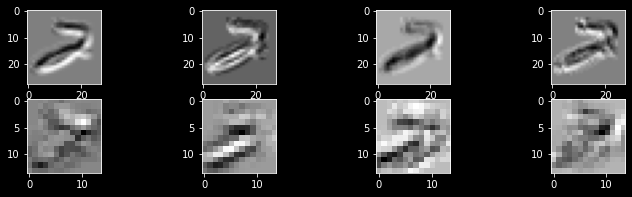

Epoch #9
training loss 0.013191618025302887
testing loss 0.1739233136177063
training accuracy 0.996
testing accuracy 0.95


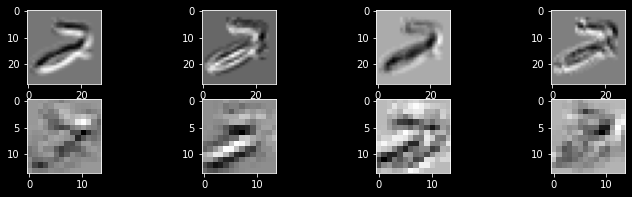

Epoch #10
training loss 0.025472130626440048
testing loss 0.3831406533718109
training accuracy 0.99
testing accuracy 0.92


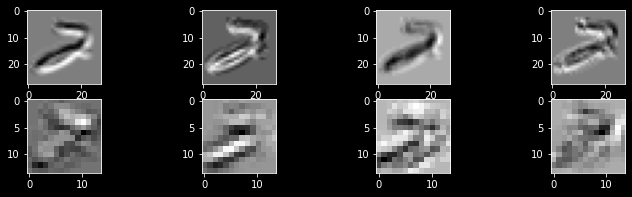

Epoch #11
training loss 0.0013017068849876523
testing loss 0.06862528622150421
training accuracy 1.0
testing accuracy 0.98


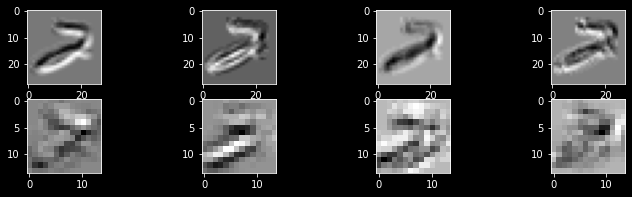

Epoch #12
training loss 0.005658412352204323
testing loss 0.16983018815517426
training accuracy 0.999
testing accuracy 0.96


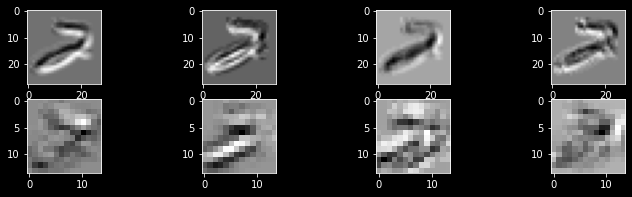

Epoch #13
training loss 0.003012704662978649
testing loss 0.13238410651683807
training accuracy 0.999
testing accuracy 0.95


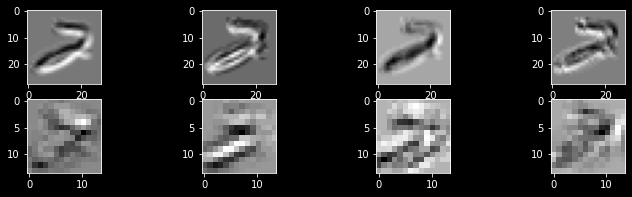

Epoch #14
training loss 0.0026522758416831493
testing loss 0.23730477690696716
training accuracy 1.0
testing accuracy 0.95


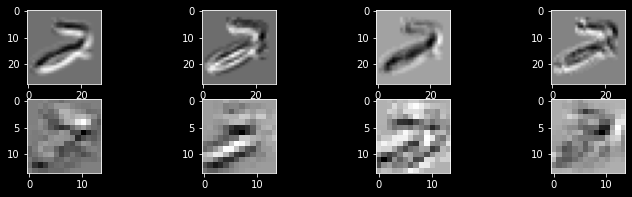

Epoch #15
training loss 0.05203144997358322
testing loss 0.5395277738571167
training accuracy 0.981
testing accuracy 0.92


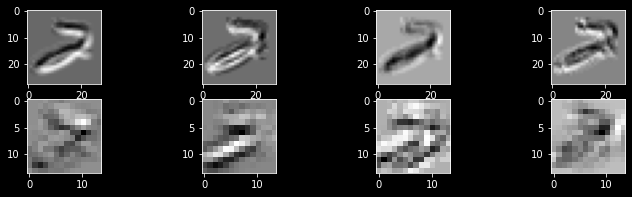

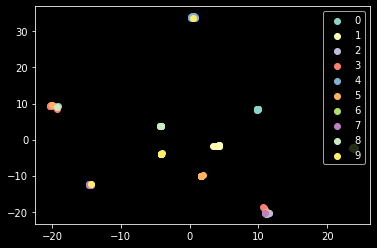

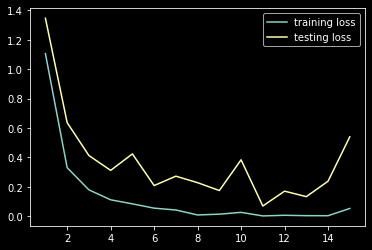

In [16]:
network = Network_dropout(0.5)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

Dropout rate 0.8

Epoch #1
training loss 2.0955793857574463
testing loss 2.1247472763061523
training accuracy 0.356
testing accuracy 0.3


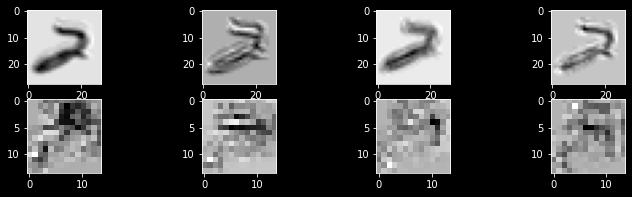

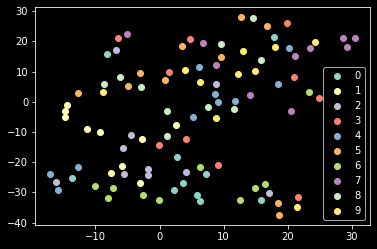

Epoch #2
training loss 0.5591971278190613
testing loss 0.7641865611076355
training accuracy 0.833
testing accuracy 0.73


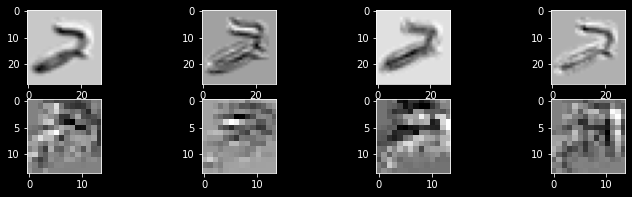

Epoch #3
training loss 0.30435019731521606
testing loss 0.5616413950920105
training accuracy 0.903
testing accuracy 0.81


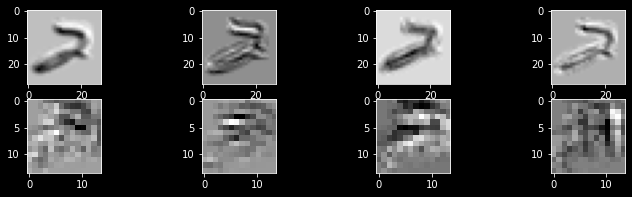

Epoch #4
training loss 0.1422145962715149
testing loss 0.38288310170173645
training accuracy 0.967
testing accuracy 0.86


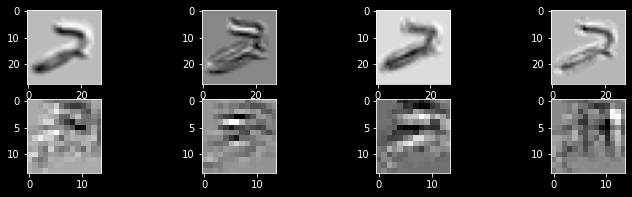

Epoch #5
training loss 0.10413388907909393
testing loss 0.2773303687572479
training accuracy 0.974
testing accuracy 0.9


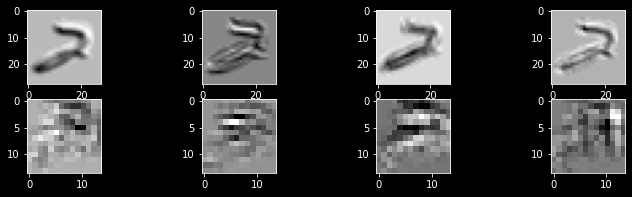

Epoch #6
training loss 0.047142960131168365
testing loss 0.2569725215435028
training accuracy 0.993
testing accuracy 0.89


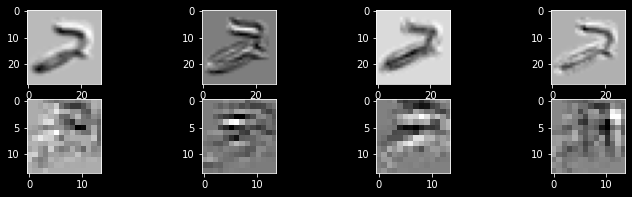

Epoch #7
training loss 0.02941928245127201
testing loss 0.2718732953071594
training accuracy 0.993
testing accuracy 0.92


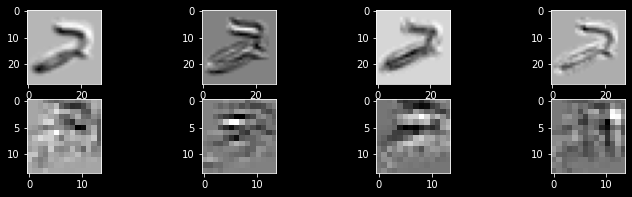

Epoch #8
training loss 0.011551756411790848
testing loss 0.1725451648235321
training accuracy 0.999
testing accuracy 0.94


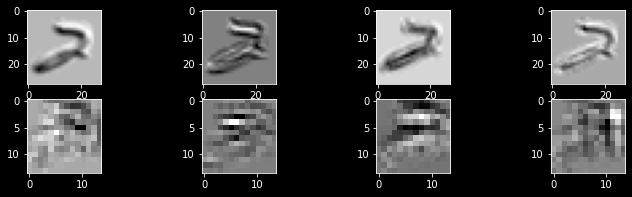

Epoch #9
training loss 0.014839382842183113
testing loss 0.19341592490673065
training accuracy 0.996
testing accuracy 0.9


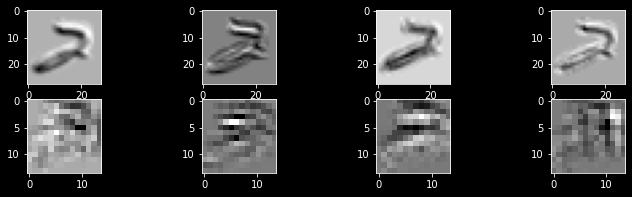

Epoch #10
training loss 0.006988698150962591
testing loss 0.22368501126766205
training accuracy 0.998
testing accuracy 0.91


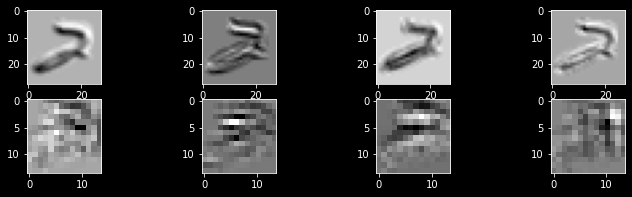

Epoch #11
training loss 0.003384336596354842
testing loss 0.33636748790740967
training accuracy 0.999
testing accuracy 0.93


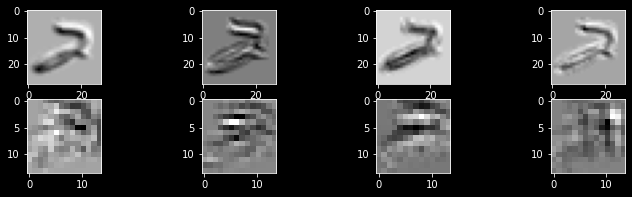

Epoch #12
training loss 0.006868873257189989
testing loss 0.27371302247047424
training accuracy 0.999
testing accuracy 0.93


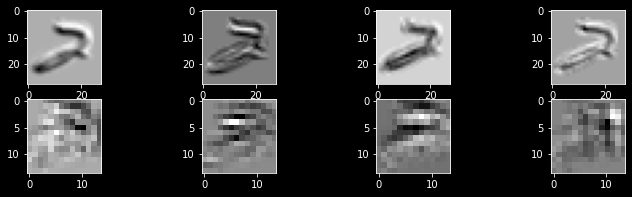

Epoch #13
training loss 0.01579415239393711
testing loss 0.3571814000606537
training accuracy 0.994
testing accuracy 0.92


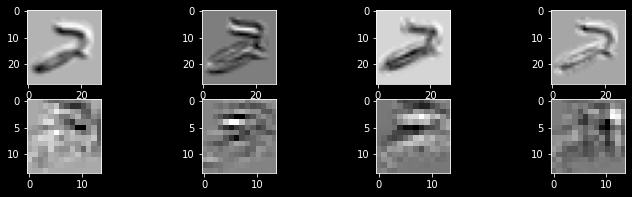

Epoch #14
training loss 0.002118611941114068
testing loss 0.24494722485542297
training accuracy 0.999
testing accuracy 0.96


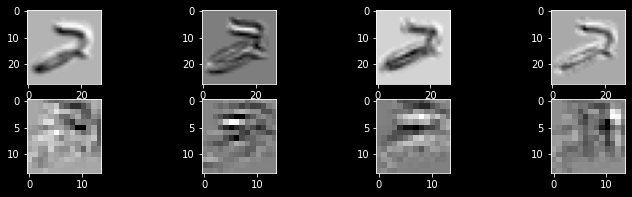

Epoch #15
training loss 0.0005685072392225266
testing loss 0.20977140963077545
training accuracy 1.0
testing accuracy 0.93


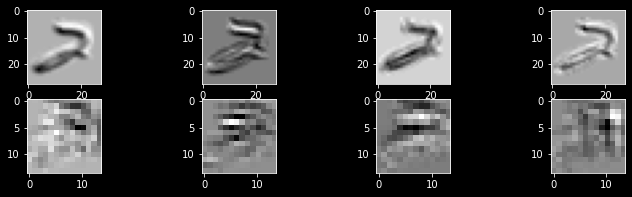

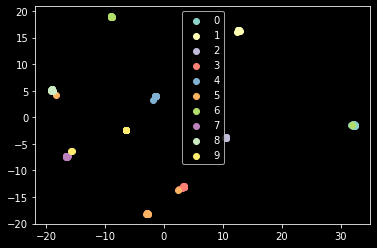

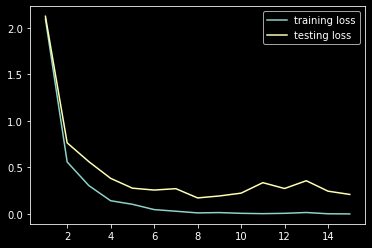

In [17]:
network = Network_dropout(0.8)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

The results are not consistent. A general trend in accuracy I observed is that it is higher fro 0.2, kind of similar for 0.5, slightly less for 0.8. But at times I observe different results.
Above, we can see accuracy for 0.8 dropout rate is 90%, while it is 93 for 0.5 drop out rate and 96 for 0.2 dropout rate. However, the results change after each run

Compared to model without dropout, this model seems to converge at slightly slower pace than without drop out, the overall accuracy in both training, testing appears to be similar.

# Batch Norm along with drop out
Question - 7

In [18]:
class Network_batchnorm(nn.Module):
    def __init__(self, p):
        self.p = p
        super(Network_batchnorm, self).__init__()
        self.conv1 = nn.Conv2d(1,4,5,padding = 2)
        self.conv1_ = nn.Sequential(nn.ReLU(),
                                    nn.MaxPool2d(2,2)) 
        self.conv2 = nn.Conv2d(4,4,5,padding = 2)
        self.conv2_ = nn.Sequential(nn.ReLU(), 
                                    nn.MaxPool2d(2,2)) 
        self.mlp1 = nn.Sequential(nn.Linear( 196, 49), 
                                    nn.BatchNorm1d(49),
                                    nn.ReLU(),
                                    nn.Dropout(p = self.p))
        self.mlp2 = nn.Linear(49, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        x = self.conv2_(x)
        x = x.view(-1, 196)
        x = self.mlp1(x)
        x = self.mlp2(x)
        return x
    
    def viz(self, x):
        ret = []
        x = self.conv1(x)
        ret.append(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        ret.append(x)
        return ret


Epoch #1
training loss 0.9973887801170349
testing loss 1.0601376295089722
training accuracy 0.826
testing accuracy 0.8


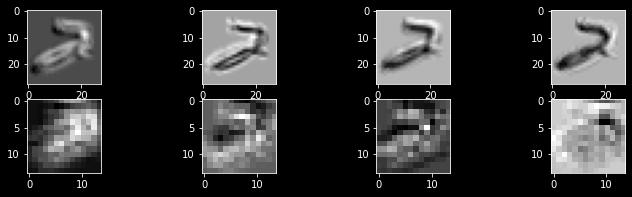

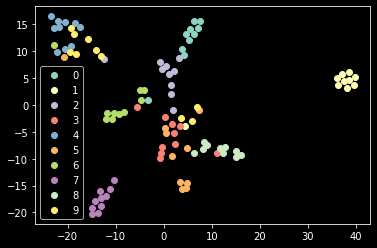

Epoch #2
training loss 0.3213898837566376
testing loss 0.38944175839424133
training accuracy 0.905
testing accuracy 0.86


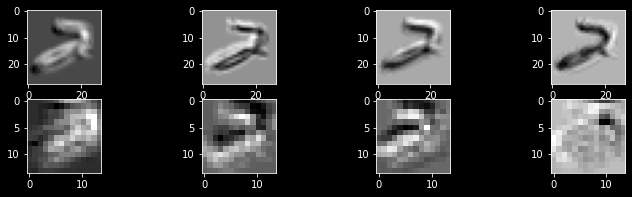

Epoch #3
training loss 0.20864441990852356
testing loss 0.2834716737270355
training accuracy 0.936
testing accuracy 0.91


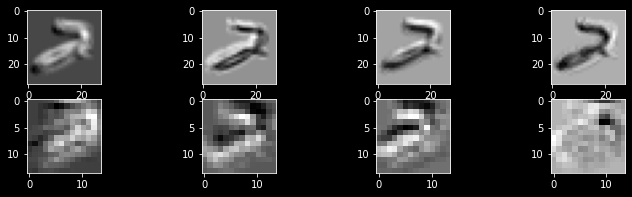

Epoch #4
training loss 0.1720273345708847
testing loss 0.29366591572761536
training accuracy 0.939
testing accuracy 0.91


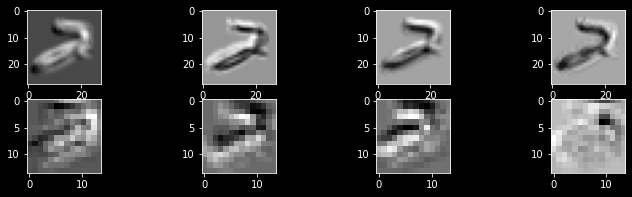

Epoch #5
training loss 0.1086038202047348
testing loss 0.18319649994373322
training accuracy 0.97
testing accuracy 0.95


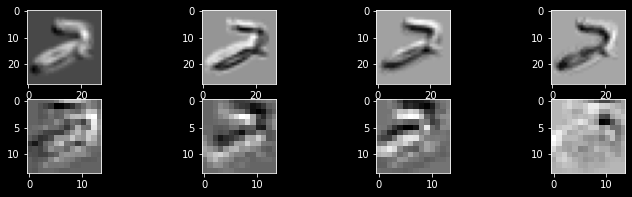

Epoch #6
training loss 0.1215706393122673
testing loss 0.2410571426153183
training accuracy 0.969
testing accuracy 0.93


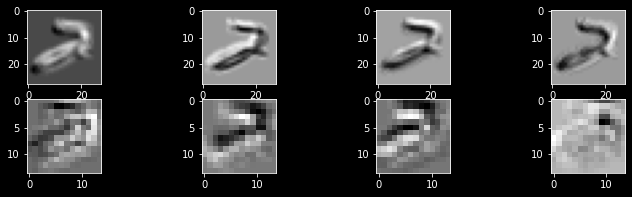

Epoch #7
training loss 0.0855715349316597
testing loss 0.2743234932422638
training accuracy 0.969
testing accuracy 0.91


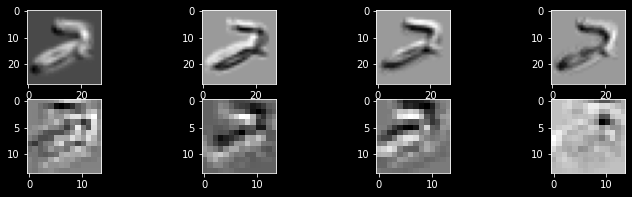

Epoch #8
training loss 0.0628308355808258
testing loss 0.1901634782552719
training accuracy 0.981
testing accuracy 0.91


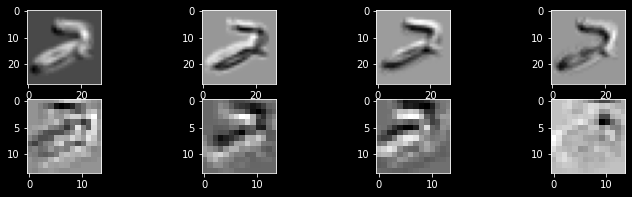

Epoch #9
training loss 0.03405304253101349
testing loss 0.18507857620716095
training accuracy 0.993
testing accuracy 0.95


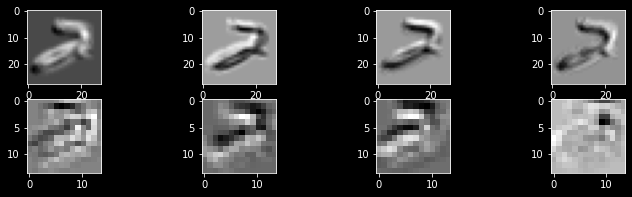

Epoch #10
training loss 0.0318615697324276
testing loss 0.11532701551914215
training accuracy 0.988
testing accuracy 0.96


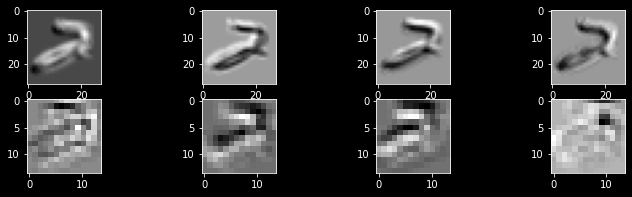

Epoch #11
training loss 0.0075281583704054356
testing loss 0.11371495574712753
training accuracy 1.0
testing accuracy 0.96


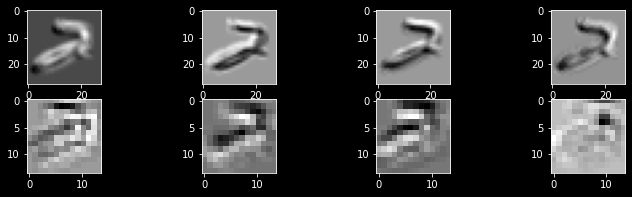

Epoch #12
training loss 0.032761383801698685
testing loss 0.1897972822189331
training accuracy 0.988
testing accuracy 0.94


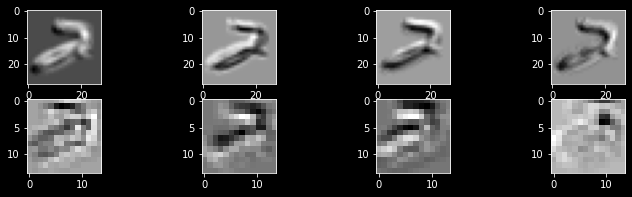

Epoch #13
training loss 0.00950589682906866
testing loss 0.16407501697540283
training accuracy 0.997
testing accuracy 0.93


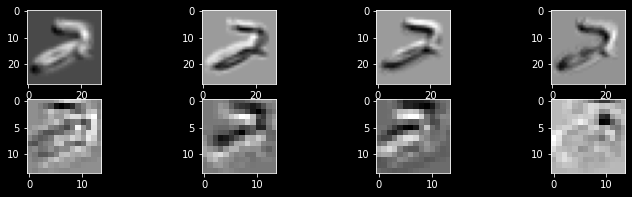

Epoch #14
training loss 0.03456706181168556
testing loss 0.3471492826938629
training accuracy 0.988
testing accuracy 0.92


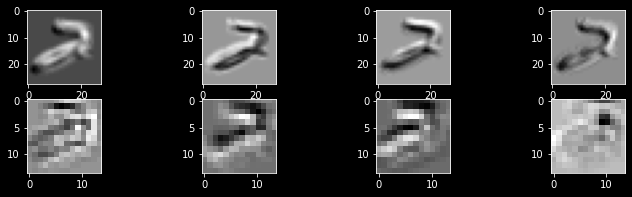

Epoch #15
training loss 0.0015470333164557815
testing loss 0.09562588483095169
training accuracy 1.0
testing accuracy 0.97


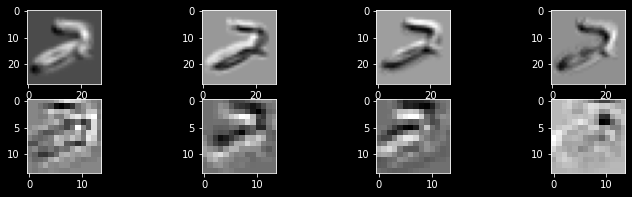

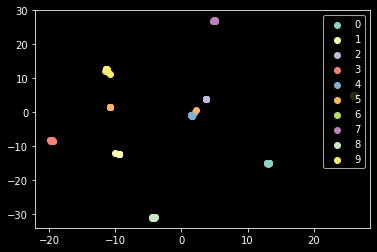

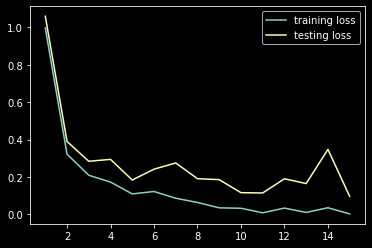

In [19]:
network = Network_batchnorm(0.2)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

Batch norm gives good accuracy, the accuracy of just drop out or vanilla rmsprop is not very consistent, and changes with every run. The accuracy produced by batch norm seems somewhat more consistent at around 96-97%. In the above results we can see 99% accuracy for both rmsprop and batchnorm. After a certain point there isn't room for improvement. So, batch norm doesn't add much. But a general trend I observed was that batchnorm tends to be slightly better.

However, the loss produced by batch norm is far less than just vanilla or dropout. This is perhaps a better metic to compare the methods.

The order of performance I observed is 

> Batchnorm > dropout > vanilla rmsprop

In [20]:
torch.save(network, "model/mycnn")

In [21]:
import torch
net = Network_batchnorm()
net = torch.load("model/mycnn")

TypeError: Network_batchnorm.__init__() missing 1 required positional argument: 'p'

Epoch #1
training loss 0.2745365798473358
testing loss 0.33310553431510925
training accuracy 0.992
testing accuracy 0.99


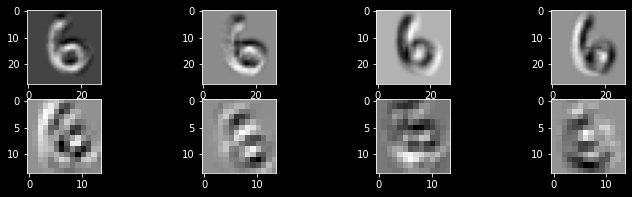

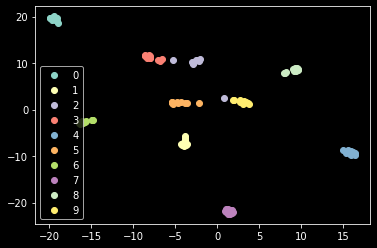

Epoch #2
training loss 0.04744572937488556
testing loss 0.0561298169195652
training accuracy 0.993
testing accuracy 1.0


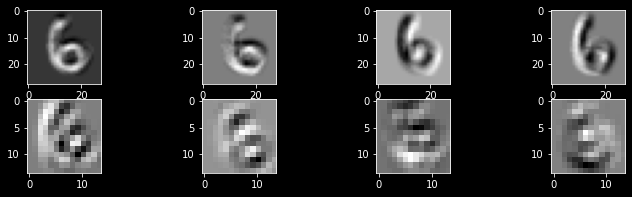

Epoch #3
training loss 0.02292797341942787
testing loss 0.05068649724125862
training accuracy 0.998
testing accuracy 0.98


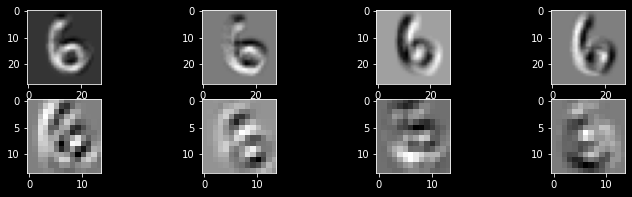

Epoch #4
training loss 0.02219676412642002
testing loss 0.04106907919049263
training accuracy 0.994
testing accuracy 0.99


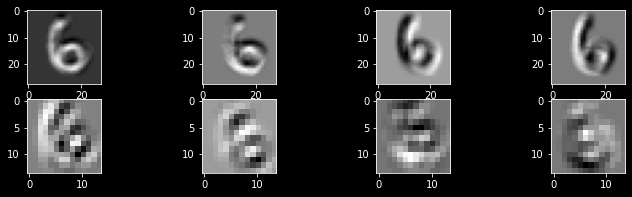

Epoch #5
training loss 0.010111574083566666
testing loss 0.03015141561627388
training accuracy 1.0
testing accuracy 0.99


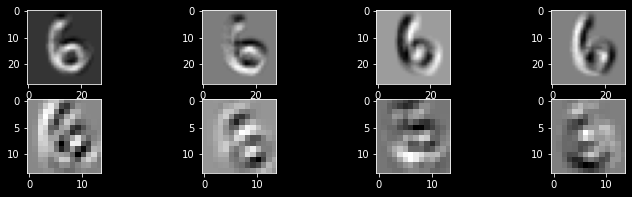

Epoch #6
training loss 0.011046743020415306
testing loss 0.035847920924425125
training accuracy 0.998
testing accuracy 0.99


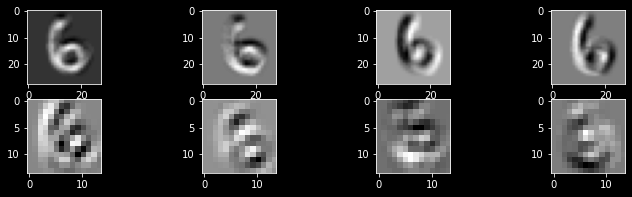

Epoch #7
training loss 0.0042176139540970325
testing loss 0.007099959068000317
training accuracy 1.0
testing accuracy 1.0


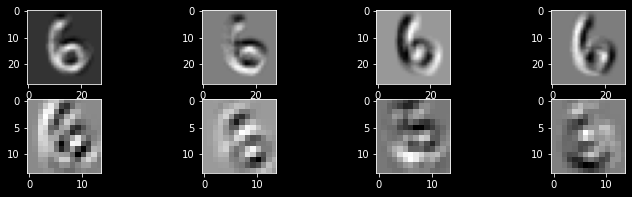

Epoch #8
training loss 0.003130237339064479
testing loss 0.00944891944527626
training accuracy 1.0
testing accuracy 1.0


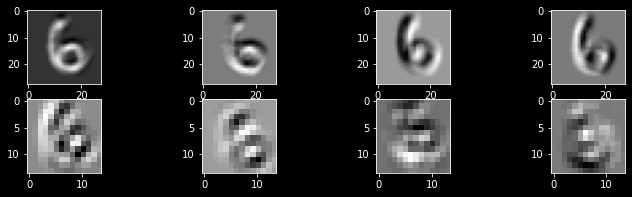

Epoch #9
training loss 0.0029454787727445364
testing loss 0.025933032855391502
training accuracy 1.0
testing accuracy 0.98


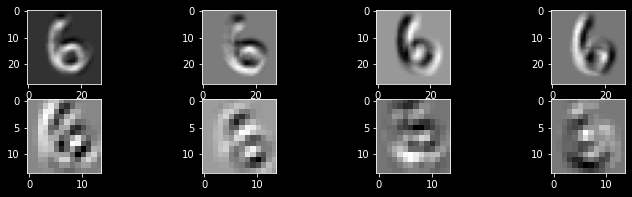

Epoch #10
training loss 0.006766428239643574
testing loss 0.04028451070189476
training accuracy 0.999
testing accuracy 0.97


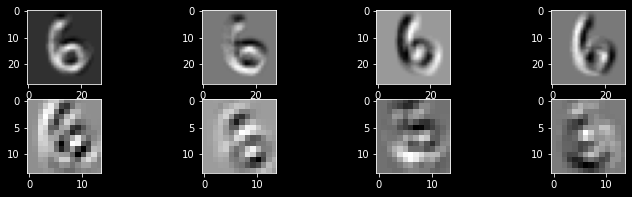

Epoch #11
training loss 0.0006722436519339681
testing loss 0.010426401160657406
training accuracy 1.0
testing accuracy 1.0


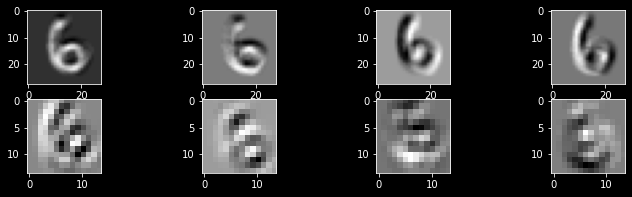

Epoch #12
training loss 0.0007733328966423869
testing loss 0.008367305621504784
training accuracy 1.0
testing accuracy 1.0


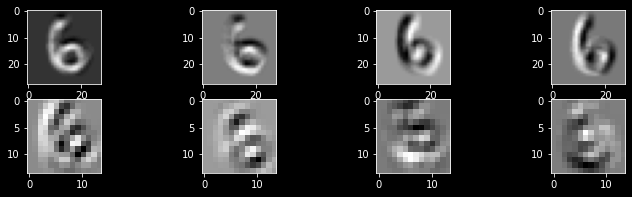

Epoch #13
training loss 0.004105377476662397
testing loss 0.01641160249710083
training accuracy 0.999
testing accuracy 1.0


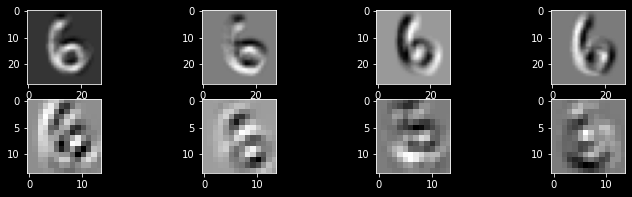

Epoch #14
training loss 0.0006983240600675344
testing loss 0.02470191940665245
training accuracy 1.0
testing accuracy 0.99


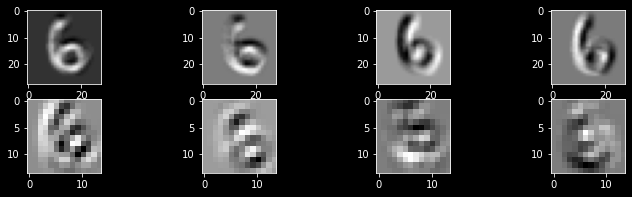

Epoch #15
training loss 0.00231952010653913
testing loss 0.05297314003109932
training accuracy 1.0
testing accuracy 0.97


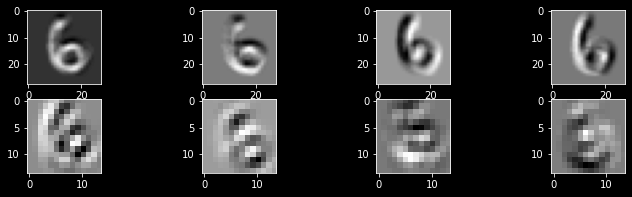

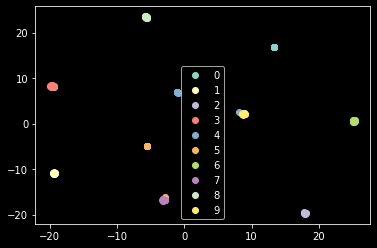

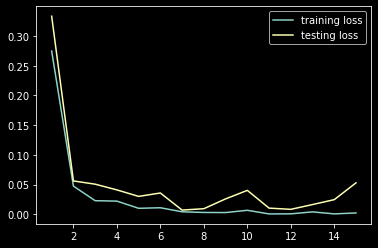

In [ ]:
optimizer_rmsprop = optim.RMSprop(net.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(net, x_train, y_train, 15, 15, optimizer_rmsprop)